# $\textbf{Predicting LFSR States Using Feedforward Neural Networks}$
$\text{Author: Ryan Burns}$

#### $\textbf{Linear Feedback Shift Registers (LFSRs)}$
$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

#### $\textbf{Prediction of LFSR State }n + 1\textbf{ Given State }n$
$\text{Suppose we are given an arbitrary LFSR feedback polynomial and we build a representation of the LFSR in software. Using this LFSR, and}$
$\text{assuming the feedback polynomial is primitive in a polynomial ring of fixed degree over }GF(2)\text{, we can generate a maximum-length binary}$
$\text{sequence which has well-documented correlation properties which make them desirable building blocks for stream ciphers or spread-spectrum}$
$\text{codes, to name a few examples. On their own, LFSRs do not afford any real cryptographic protection, being famously susceptible to correlation}$
$\text{attacks. Speaking of attacks, our goal in this notebook is to demonstrate that we can use a }\textit{very}\text{ simple neural network to predict LFSR behavior.}$
$\text{Specifically, we posit that a two-layer (i.e., single hidden-layer) feedforward neural network can readily predict the state-evolution of an arbitrary}$
$\text{LFSR. For simplicity, we constrain this network to have a very specific architecture. Its input layer consists of a fixed-length binary vector that}$
$\text{represents the LFSR state vector at some time index (epoch) }n\text{. We use the ground truth register state at index / epoch }n + 1\text{ to train a the network}$
$\text{to develop a latent representation of the finite field recursion. Both layers of the network are sigmoid connections, representing soft approximations}$
$\text{of boolean gates, outputing activations in the unit interval, }[0,1].\text{ These layers assume no bias terms, only weighted combinations of inputs. For}$
$\text{an LFSR of recursion-order/polynomial degree }deg\text{, the first (and only) hidden layer consists a total of }2\times deg\text{ weighted sigmoidal activations.}$
$\text{The output layer consists of the }deg\text{ total activations predicting }deg\text{ total bits in the LFSR state vector at epoch }n + 1\text{, for all }n\text{. These binary}$
$\text{activations are trained against the true LFSR state vectors at these indices }n + 1\text{ using a binary cross-entropy error function. The population of}$
$\text{observations are the }deg\text{-length LFSR states across all epochs in one full }m\text{-sequence period / cycle. The labels for the error function are the }$
$deg\text{-length state vector values upon 1 iteration of the LFSR recursion, per observation.}$

#### $\textbf{This Notebook}$
$\text{This notebook prototypes a feedforward binary (biasless) neural network using Keras, training it as described above using RMSprop. The net}$
$\text{is given too few degrees of freedom to completely memorize the sequences, so it must learn a latent representation of the underlying finite field}$
$\text{mathematics defining the recurrence relation. After sufficiently many training epochs, the model has been tested to converge to 100}\%\text{ accuracy}$
$\text{for all degree-10 primitive polynomials in the file 10.txt. Primitive polynomials defining }m\text{-sequences for other polynomial degrees are available}$
$\text{for download at the following site: }\textit{https://users.ece.cmu.edu/~koopman/lfsr/index.html}.$

$\text{In addition to training the network, we animate the results in a plot which depicts the time-evolution of the LFSR recursion and the neural}$
$\text{network's state predictions. In addition, options are provided for plotting the correlation properties of the }m\text{-sequence training data and the Keras}$
$\text{model metrics vs training epoch, respectively. Documentation and source code for all the functions below can be found in this repo's modules.}$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange, max

# Galois / LFSR utilities
from galois_tools import *
from m_sequence_viz import *
from lfsr_network_viz import *
from ml_utils import *

# Plotting functionality
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

# Tensorflow/Keras functionality
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

### $\textbf{Plotting Macro (Requires IPython)}$

In [2]:
%matplotlib notebook

### $\textbf{Specify LFSR & Neural Net Parameters}$

In [3]:
###########################
# Specify LFSR parameters #
###########################

# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

# Primitive polynomial choice
p = 16 # (index in catalog)

###############################
# Network training parameters #
###############################

# Number of RMSprop training epochs
N_epoch = 16000

# Batch size equal to m-sequence length
N_batch = 2**deg - 1

# Learning rate for RMSprop
learning_rate = 0.001

#########################
# Behavioral parameters #
#########################

# Turn ON/OFF correlation plot
plot_correlations = True

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [4]:
#############################################################
# Load coeff. of primitive polynomials over GF(2) from file #
#############################################################

# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg)

###########################################################
# Generate linear feedback shift registers w/ polynomials #
###########################################################

# Define a bank of LFSRs - 1 per polynomial in the catalog
LFSRs = [LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))]

### $\textbf{Visualize Auto- & Cross-Correlations of Two m-Sequences}$

<IPython.core.display.Javascript object>


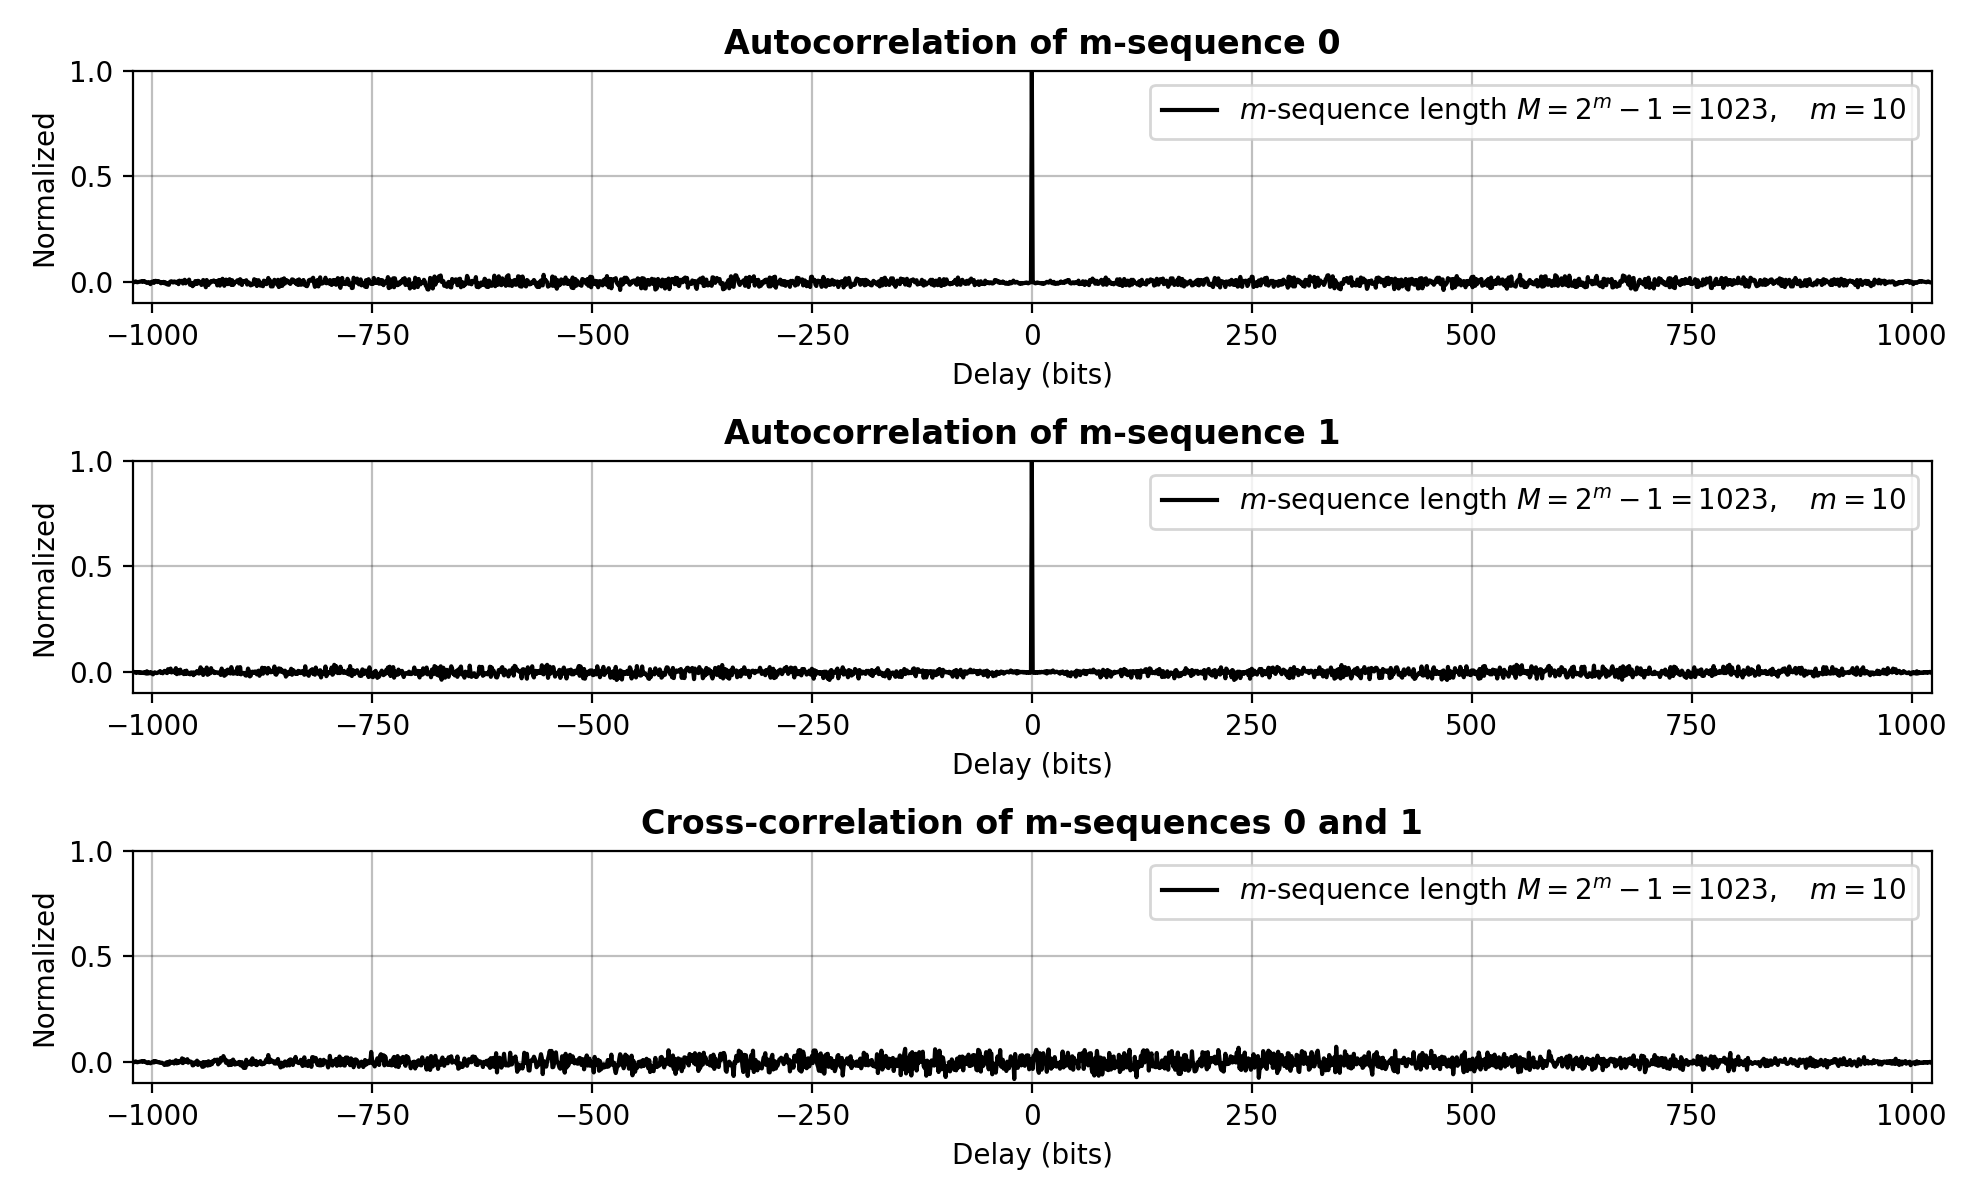

In [5]:
# Optional correlation plot...
if plot_correlations:

    ##################################################
    # Generate m-sequences for each LFSR in the bank #
    ##################################################

    # Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
    m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

    # Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
    algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

    ###################################################
    # Visualize correlation properties of m-sequences #
    ###################################################

    # Plot the correlations of the 1st 2 m-sequences generated above
    correlation_example(m_sequence0=algebraic_m_sequences[p,:], 
        m_sequence1=algebraic_m_sequences[p + 1,:],  deg=deg)

### $\textbf{Form Observations of }n^{\text{th}}\textbf{ LFSR State for Prediction of }(n + 1)^\text{st}\textbf{ State, for }n=0,1,2,\ldots$

In [6]:
#########################################################
# Buffer in b[n] a total of 2^deg + deg m-sequence bits #
#########################################################

# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
b = vstack(tuple(register.stream(2**deg + deg) for register in LFSRs))

########################################################
# n'th LFSR register state observations, n = 0,1,2,... #
########################################################

# Input LFSR windows (deg-bit observation vectors)
X = array([b[p,n:(n + deg)] for n in range(b.shape[1] - deg - 1)])

############################################################
# (n+1)'st LFSR register state observations, n = 0,1,2,... #
############################################################

# Target LFSR windows, 1 epoch into future from X
Y = array([b[p,(n + 1):(1 + n + deg)] for n in range(b.shape[1] - deg - 1)])

### $\textbf{Define Feedforward Binary Neural Network}$

In [7]:
# Use Keras to define feedforward binary neural network, with
# two sigmoidal layers (without bias terms) for estimation of
# the LFSR state vector at epoch n + 1 from the state at epoch n
model = feedforward_lfsr_predictor(deg=deg, 
    learning_rate=learning_rate, print_summary=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden (Dense)               (None, 20)                200       
_________________________________________________________________
output (Dense)               (None, 10)                200       
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


### $\textbf{Fit Sigmoid Model to Predict Register State }n + 1\textbf{ from State }n$

In [8]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # state vectot "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=0, # (use everything)
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False);

Train on 1023 samples
Epoch 1/16000
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.7166 - true_positives: 2670.0000 - true_negatives: 2684.0000 - false_positives: 2426.0000 - false_negatives: 2450.0000
Epoch 2/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7130 - true_positives: 2633.0000 - true_negatives: 2721.0000 - false_positives: 2389.0000 - false_negatives: 2487.0000
Epoch 3/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7106 - true_positives: 2609.0000 - true_negatives: 2753.0000 - false_positives: 2357.0000 - false_negatives: 2511.0000
Epoch 4/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7086 - true_positives: 2602.0000 - true_negatives: 2778.0000 - false_positives: 2332.0000 - false_negatives: 2518.0000
Epoch 5/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7070 - true_positives: 2605.0000 - true_negatives: 2795.0000 - false_positives: 2315.00

Epoch 42/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6774 - true_positives: 2924.0000 - true_negatives: 3257.0000 - false_positives: 1853.0000 - false_negatives: 2196.0000
Epoch 43/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6768 - true_positives: 2934.0000 - true_negatives: 3274.0000 - false_positives: 1836.0000 - false_negatives: 2186.0000
Epoch 44/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6762 - true_positives: 2952.0000 - true_negatives: 3284.0000 - false_positives: 1826.0000 - false_negatives: 2168.0000
Epoch 45/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6757 - true_positives: 2967.0000 - true_negatives: 3292.0000 - false_positives: 1818.0000 - false_negatives: 2153.0000
Epoch 46/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6751 - true_positives: 2980.0000 - true_negatives: 3304.0000 - false_positives: 1806.0000 - false_negati

Epoch 83/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6561 - true_positives: 3588.0000 - true_negatives: 3755.0000 - false_positives: 1355.0000 - false_negatives: 1532.0000
Epoch 84/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6556 - true_positives: 3607.0000 - true_negatives: 3767.0000 - false_positives: 1343.0000 - false_negatives: 1513.0000
Epoch 85/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6551 - true_positives: 3629.0000 - true_negatives: 3776.0000 - false_positives: 1334.0000 - false_negatives: 1491.0000
Epoch 86/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6546 - true_positives: 3638.0000 - true_negatives: 3787.0000 - false_positives: 1323.0000 - false_negatives: 1482.0000
Epoch 87/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6541 - true_positives: 3672.0000 - true_negatives: 3791.0000 - false_positives: 1319.0000 - false_negati

Epoch 124/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6364 - true_positives: 4220.0000 - true_negatives: 4053.0000 - false_positives: 1057.0000 - false_negatives: 900.0000
Epoch 125/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6360 - true_positives: 4254.0000 - true_negatives: 4025.0000 - false_positives: 1085.0000 - false_negatives: 866.0000
Epoch 126/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6355 - true_positives: 4229.0000 - true_negatives: 4068.0000 - false_positives: 1042.0000 - false_negatives: 891.0000
Epoch 127/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6350 - true_positives: 4267.0000 - true_negatives: 4040.0000 - false_positives: 1070.0000 - false_negatives: 853.0000
Epoch 128/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6345 - true_positives: 4243.0000 - true_negatives: 4083.0000 - false_positives: 1027.0000 - false_negat

Epoch 165/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6164 - true_positives: 4504.0000 - true_negatives: 4260.0000 - false_positives: 850.0000 - false_negatives: 616.0000
Epoch 166/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6159 - true_positives: 4465.0000 - true_negatives: 4303.0000 - false_positives: 807.0000 - false_negatives: 655.0000
Epoch 167/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6154 - true_positives: 4513.0000 - true_negatives: 4266.0000 - false_positives: 844.0000 - false_negatives: 607.0000
Epoch 168/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6149 - true_positives: 4477.0000 - true_negatives: 4310.0000 - false_positives: 800.0000 - false_negatives: 643.0000
Epoch 169/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6144 - true_positives: 4527.0000 - true_negatives: 4274.0000 - false_positives: 836.0000 - false_negatives:

Epoch 206/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5959 - true_positives: 4569.0000 - true_negatives: 4420.0000 - false_positives: 690.0000 - false_negatives: 551.0000
Epoch 207/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5954 - true_positives: 4622.0000 - true_negatives: 4387.0000 - false_positives: 723.0000 - false_negatives: 498.0000
Epoch 208/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5949 - true_positives: 4568.0000 - true_negatives: 4422.0000 - false_positives: 688.0000 - false_negatives: 552.0000
Epoch 209/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5944 - true_positives: 4622.0000 - true_negatives: 4390.0000 - false_positives: 720.0000 - false_negatives: 498.0000
Epoch 210/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5939 - true_positives: 4571.0000 - true_negatives: 4428.0000 - false_positives: 682.0000 - false_negatives:

Epoch 247/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5749 - true_positives: 4672.0000 - true_negatives: 4472.0000 - false_positives: 638.0000 - false_negatives: 448.0000
Epoch 248/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5744 - true_positives: 4621.0000 - true_negatives: 4532.0000 - false_positives: 578.0000 - false_negatives: 499.0000
Epoch 249/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5739 - true_positives: 4675.0000 - true_negatives: 4479.0000 - false_positives: 631.0000 - false_negatives: 445.0000
Epoch 250/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5734 - true_positives: 4625.0000 - true_negatives: 4534.0000 - false_positives: 576.0000 - false_negatives: 495.0000
Epoch 251/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5729 - true_positives: 4679.0000 - true_negatives: 4485.0000 - false_positives: 625.0000 - false_negatives:

Epoch 288/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5535 - true_positives: 4661.0000 - true_negatives: 4572.0000 - false_positives: 538.0000 - false_negatives: 459.0000
Epoch 289/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5530 - true_positives: 4717.0000 - true_negatives: 4525.0000 - false_positives: 585.0000 - false_negatives: 403.0000
Epoch 290/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5525 - true_positives: 4661.0000 - true_negatives: 4576.0000 - false_positives: 534.0000 - false_negatives: 459.0000
Epoch 291/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5519 - true_positives: 4717.0000 - true_negatives: 4528.0000 - false_positives: 582.0000 - false_negatives: 403.0000
Epoch 292/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5514 - true_positives: 4660.0000 - true_negatives: 4578.0000 - false_positives: 532.0000 - false_negatives:

Epoch 329/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5316 - true_positives: 4754.0000 - true_negatives: 4565.0000 - false_positives: 545.0000 - false_negatives: 366.0000
Epoch 330/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5311 - true_positives: 4675.0000 - true_negatives: 4614.0000 - false_positives: 496.0000 - false_negatives: 445.0000
Epoch 331/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5306 - true_positives: 4755.0000 - true_negatives: 4566.0000 - false_positives: 544.0000 - false_negatives: 365.0000
Epoch 332/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5300 - true_positives: 4676.0000 - true_negatives: 4617.0000 - false_positives: 493.0000 - false_negatives: 444.0000
Epoch 333/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5295 - true_positives: 4757.0000 - true_negatives: 4568.0000 - false_positives: 542.0000 - false_negatives:

Epoch 370/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5095 - true_positives: 4692.0000 - true_negatives: 4656.0000 - false_positives: 454.0000 - false_negatives: 428.0000
Epoch 371/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5090 - true_positives: 4761.0000 - true_negatives: 4579.0000 - false_positives: 531.0000 - false_negatives: 359.0000
Epoch 372/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5084 - true_positives: 4690.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 430.0000
Epoch 373/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5079 - true_positives: 4761.0000 - true_negatives: 4579.0000 - false_positives: 531.0000 - false_negatives: 359.0000
Epoch 374/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5073 - true_positives: 4690.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives:

Epoch 411/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4873 - true_positives: 4778.0000 - true_negatives: 4612.0000 - false_positives: 498.0000 - false_negatives: 342.0000
Epoch 412/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4868 - true_positives: 4708.0000 - true_negatives: 4684.0000 - false_positives: 426.0000 - false_negatives: 412.0000
Epoch 413/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4862 - true_positives: 4777.0000 - true_negatives: 4612.0000 - false_positives: 498.0000 - false_negatives: 343.0000
Epoch 414/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4857 - true_positives: 4709.0000 - true_negatives: 4684.0000 - false_positives: 426.0000 - false_negatives: 411.0000
Epoch 415/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4851 - true_positives: 4776.0000 - true_negatives: 4612.0000 - false_positives: 498.0000 - false_negatives:

Epoch 452/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4652 - true_positives: 4722.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 398.0000
Epoch 453/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4647 - true_positives: 4796.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 324.0000
Epoch 454/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4642 - true_positives: 4725.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 395.0000
Epoch 455/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4636 - true_positives: 4798.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 322.0000
Epoch 456/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4631 - true_positives: 4726.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives:

Epoch 493/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4435 - true_positives: 4810.0000 - true_negatives: 4664.0000 - false_positives: 446.0000 - false_negatives: 310.0000
Epoch 494/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4430 - true_positives: 4747.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negatives: 373.0000
Epoch 495/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4425 - true_positives: 4810.0000 - true_negatives: 4665.0000 - false_positives: 445.0000 - false_negatives: 310.0000
Epoch 496/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4419 - true_positives: 4748.0000 - true_negatives: 4724.0000 - false_positives: 386.0000 - false_negatives: 372.0000
Epoch 497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4414 - true_positives: 4811.0000 - true_negatives: 4666.0000 - false_positives: 444.0000 - false_negatives:

Epoch 534/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4223 - true_positives: 4759.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negatives: 361.0000
Epoch 535/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4218 - true_positives: 4819.0000 - true_negatives: 4691.0000 - false_positives: 419.0000 - false_negatives: 301.0000
Epoch 536/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4213 - true_positives: 4760.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negatives: 360.0000
Epoch 537/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4208 - true_positives: 4819.0000 - true_negatives: 4690.0000 - false_positives: 420.0000 - false_negatives: 301.0000
Epoch 538/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4203 - true_positives: 4760.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negatives:

Epoch 575/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4017 - true_positives: 4828.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 292.0000
Epoch 576/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4012 - true_positives: 4778.0000 - true_negatives: 4765.0000 - false_positives: 345.0000 - false_negatives: 342.0000
Epoch 577/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4007 - true_positives: 4831.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negatives: 289.0000
Epoch 578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4002 - true_positives: 4781.0000 - true_negatives: 4765.0000 - false_positives: 345.0000 - false_negatives: 339.0000
Epoch 579/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3997 - true_positives: 4832.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives:

Epoch 616/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3817 - true_positives: 4785.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 335.0000
Epoch 617/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3812 - true_positives: 4845.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 275.0000
Epoch 618/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3807 - true_positives: 4785.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 335.0000
Epoch 619/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3802 - true_positives: 4847.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 273.0000
Epoch 620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3798 - true_positives: 4785.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives:

Epoch 657/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3624 - true_positives: 4857.0000 - true_negatives: 4738.0000 - false_positives: 372.0000 - false_negatives: 263.0000
Epoch 658/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3620 - true_positives: 4799.0000 - true_negatives: 4794.0000 - false_positives: 316.0000 - false_negatives: 321.0000
Epoch 659/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3615 - true_positives: 4855.0000 - true_negatives: 4739.0000 - false_positives: 371.0000 - false_negatives: 265.0000
Epoch 660/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3610 - true_positives: 4797.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 323.0000
Epoch 661/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3606 - true_positives: 4857.0000 - true_negatives: 4741.0000 - false_positives: 369.0000 - false_negatives:

Epoch 698/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3440 - true_positives: 4814.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 306.0000
Epoch 699/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3435 - true_positives: 4862.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negatives: 258.0000
Epoch 700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3431 - true_positives: 4817.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 303.0000
Epoch 701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3426 - true_positives: 4863.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negatives: 257.0000
Epoch 702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3422 - true_positives: 4818.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives:

Epoch 739/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3263 - true_positives: 4858.0000 - true_negatives: 4773.0000 - false_positives: 337.0000 - false_negatives: 262.0000
Epoch 740/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3259 - true_positives: 4827.0000 - true_negatives: 4815.0000 - false_positives: 295.0000 - false_negatives: 293.0000
Epoch 741/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3255 - true_positives: 4859.0000 - true_negatives: 4774.0000 - false_positives: 336.0000 - false_negatives: 261.0000
Epoch 742/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3251 - true_positives: 4826.0000 - true_negatives: 4818.0000 - false_positives: 292.0000 - false_negatives: 294.0000
Epoch 743/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3246 - true_positives: 4860.0000 - true_negatives: 4773.0000 - false_positives: 337.0000 - false_negatives:

Epoch 780/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3095 - true_positives: 4832.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 288.0000
Epoch 781/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3091 - true_positives: 4870.0000 - true_negatives: 4775.0000 - false_positives: 335.0000 - false_negatives: 250.0000
Epoch 782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3087 - true_positives: 4831.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 289.0000
Epoch 783/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3083 - true_positives: 4872.0000 - true_negatives: 4775.0000 - false_positives: 335.0000 - false_negatives: 248.0000
Epoch 784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3079 - true_positives: 4831.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives:

Epoch 821/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2935 - true_positives: 4873.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negatives: 247.0000
Epoch 822/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2931 - true_positives: 4841.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 279.0000
Epoch 823/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2927 - true_positives: 4875.0000 - true_negatives: 4792.0000 - false_positives: 318.0000 - false_negatives: 245.0000
Epoch 824/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2924 - true_positives: 4840.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 280.0000
Epoch 825/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2920 - true_positives: 4877.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negatives:

Epoch 862/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2783 - true_positives: 4838.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 282.0000
Epoch 863/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2779 - true_positives: 4884.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 236.0000
Epoch 864/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2775 - true_positives: 4839.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 281.0000
Epoch 865/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2772 - true_positives: 4884.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 236.0000
Epoch 866/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2768 - true_positives: 4840.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives:

Epoch 903/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2638 - true_positives: 4886.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 234.0000
Epoch 904/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2635 - true_positives: 4852.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 268.0000
Epoch 905/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2631 - true_positives: 4886.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 234.0000
Epoch 906/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2628 - true_positives: 4852.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 268.0000
Epoch 907/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2624 - true_positives: 4887.0000 - true_negatives: 4817.0000 - false_positives: 293.0000 - false_negatives:

Epoch 944/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2502 - true_positives: 4860.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 260.0000
Epoch 945/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2499 - true_positives: 4892.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 228.0000
Epoch 946/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2495 - true_positives: 4860.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 260.0000
Epoch 947/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2492 - true_positives: 4892.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 228.0000
Epoch 948/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2489 - true_positives: 4860.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives:

Epoch 985/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2373 - true_positives: 4893.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 227.0000
Epoch 986/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2370 - true_positives: 4862.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 258.0000
Epoch 987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2367 - true_positives: 4894.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 226.0000
Epoch 988/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2364 - true_positives: 4862.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 258.0000
Epoch 989/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2361 - true_positives: 4894.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives:

Epoch 1026/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2253 - true_positives: 4864.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 256.0000
Epoch 1027/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2250 - true_positives: 4897.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 223.0000
Epoch 1028/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2248 - true_positives: 4864.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 256.0000
Epoch 1029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2245 - true_positives: 4898.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 222.0000
Epoch 1030/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2242 - true_positives: 4862.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negat

Epoch 1067/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2141 - true_positives: 4896.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 224.0000
Epoch 1068/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2138 - true_positives: 4871.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 249.0000
Epoch 1069/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2136 - true_positives: 4896.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 224.0000
Epoch 1070/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2133 - true_positives: 4871.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 249.0000
Epoch 1071/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2131 - true_positives: 4896.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negat

Epoch 1108/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2037 - true_positives: 4872.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 248.0000
Epoch 1109/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2034 - true_positives: 4897.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 223.0000
Epoch 1110/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2032 - true_positives: 4872.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 248.0000
Epoch 1111/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2029 - true_positives: 4896.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 224.0000
Epoch 1112/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2027 - true_positives: 4872.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negat

Epoch 1149/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1940 - true_positives: 4896.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 224.0000
Epoch 1150/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1938 - true_positives: 4876.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 244.0000
Epoch 1151/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1935 - true_positives: 4896.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 224.0000
Epoch 1152/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1933 - true_positives: 4876.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 244.0000
Epoch 1153/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1931 - true_positives: 4896.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negat

Epoch 1190/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1850 - true_positives: 4877.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 243.0000
Epoch 1191/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1848 - true_positives: 4898.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 222.0000
Epoch 1192/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1846 - true_positives: 4876.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 244.0000
Epoch 1193/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1844 - true_positives: 4898.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 222.0000
Epoch 1194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1842 - true_positives: 4877.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negat

Epoch 1231/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1768 - true_positives: 4894.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 226.0000
Epoch 1232/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1766 - true_positives: 4877.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 243.0000
Epoch 1233/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1764 - true_positives: 4895.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 225.0000
Epoch 1234/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1762 - true_positives: 4877.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 243.0000
Epoch 1235/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1760 - true_positives: 4896.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negat

Epoch 1272/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1691 - true_positives: 4875.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 245.0000
Epoch 1273/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1690 - true_positives: 4898.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 222.0000
Epoch 1274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1688 - true_positives: 4873.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 247.0000
Epoch 1275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1686 - true_positives: 4899.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 221.0000
Epoch 1276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1684 - true_positives: 4872.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 1313/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1621 - true_positives: 4895.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 225.0000
Epoch 1314/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1619 - true_positives: 4871.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 249.0000
Epoch 1315/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1618 - true_positives: 4895.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 225.0000
Epoch 1316/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1616 - true_positives: 4871.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 249.0000
Epoch 1317/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1614 - true_positives: 4895.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negat

Epoch 1354/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1556 - true_positives: 4871.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 249.0000
Epoch 1355/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1555 - true_positives: 4894.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 226.0000
Epoch 1356/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1553 - true_positives: 4871.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 249.0000
Epoch 1357/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1552 - true_positives: 4894.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 226.0000
Epoch 1358/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1550 - true_positives: 4871.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negat

Epoch 1395/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1496 - true_positives: 4894.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 226.0000
Epoch 1396/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1495 - true_positives: 4871.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 249.0000
Epoch 1397/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1494 - true_positives: 4893.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 227.0000
Epoch 1398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1492 - true_positives: 4871.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 249.0000
Epoch 1399/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1491 - true_positives: 4893.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negat

Epoch 1436/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1441 - true_positives: 4870.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 250.0000
Epoch 1437/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1440 - true_positives: 4893.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 227.0000
Epoch 1438/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1439 - true_positives: 4870.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 250.0000
Epoch 1439/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1437 - true_positives: 4893.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 227.0000
Epoch 1440/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1436 - true_positives: 4871.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negat

Epoch 1477/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1391 - true_positives: 4895.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 225.0000
Epoch 1478/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1389 - true_positives: 4872.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 248.0000
Epoch 1479/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1388 - true_positives: 4895.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 225.0000
Epoch 1480/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1387 - true_positives: 4873.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 247.0000
Epoch 1481/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1386 - true_positives: 4894.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negat

Epoch 1518/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1344 - true_positives: 4872.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 248.0000
Epoch 1519/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1343 - true_positives: 4898.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 222.0000
Epoch 1520/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1342 - true_positives: 4871.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 249.0000
Epoch 1521/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1341 - true_positives: 4898.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 222.0000
Epoch 1522/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1340 - true_positives: 4871.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negat

Epoch 1559/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1301 - true_positives: 4894.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 226.0000
Epoch 1560/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1300 - true_positives: 4870.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 250.0000
Epoch 1561/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1299 - true_positives: 4894.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 226.0000
Epoch 1562/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1298 - true_positives: 4870.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 250.0000
Epoch 1563/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1297 - true_positives: 4894.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negat

Epoch 1600/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1261 - true_positives: 4869.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 251.0000
Epoch 1601/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1261 - true_positives: 4891.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 229.0000
Epoch 1602/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1260 - true_positives: 4869.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 251.0000
Epoch 1603/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1259 - true_positives: 4891.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 229.0000
Epoch 1604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1258 - true_positives: 4870.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negat

Epoch 1641/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1225 - true_positives: 4891.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 229.0000
Epoch 1642/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1224 - true_positives: 4866.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 254.0000
Epoch 1643/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1223 - true_positives: 4891.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 229.0000
Epoch 1644/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1222 - true_positives: 4867.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 253.0000
Epoch 1645/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1222 - true_positives: 4891.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negat

Epoch 1682/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1191 - true_positives: 4867.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 253.0000
Epoch 1683/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1191 - true_positives: 4892.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 228.0000
Epoch 1684/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1190 - true_positives: 4867.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 253.0000
Epoch 1685/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1189 - true_positives: 4892.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 228.0000
Epoch 1686/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1188 - true_positives: 4868.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negat

Epoch 1723/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1160 - true_positives: 4891.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 229.0000
Epoch 1724/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1160 - true_positives: 4867.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 253.0000
Epoch 1725/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1159 - true_positives: 4891.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 229.0000
Epoch 1726/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1158 - true_positives: 4867.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 253.0000
Epoch 1727/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1157 - true_positives: 4891.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negat

Epoch 1764/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1132 - true_positives: 4868.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 252.0000
Epoch 1765/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1131 - true_positives: 4890.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 230.0000
Epoch 1766/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1130 - true_positives: 4869.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 251.0000
Epoch 1767/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1130 - true_positives: 4892.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 228.0000
Epoch 1768/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1129 - true_positives: 4868.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negat

Epoch 1805/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1105 - true_positives: 4891.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 229.0000
Epoch 1806/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1104 - true_positives: 4869.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 251.0000
Epoch 1807/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1104 - true_positives: 4890.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 230.0000
Epoch 1808/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1103 - true_positives: 4869.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 251.0000
Epoch 1809/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1103 - true_positives: 4889.0000 - true_negatives: 4852.0000 - false_positives: 258.0000 - false_negat

Epoch 1846/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1080 - true_positives: 4868.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 252.0000
Epoch 1847/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1080 - true_positives: 4889.0000 - true_negatives: 4852.0000 - false_positives: 258.0000 - false_negatives: 231.0000
Epoch 1848/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1079 - true_positives: 4868.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 252.0000
Epoch 1849/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1079 - true_positives: 4890.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 230.0000
Epoch 1850/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1078 - true_positives: 4867.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negat

Epoch 1887/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1058 - true_positives: 4890.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 230.0000
Epoch 1888/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1057 - true_positives: 4868.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 252.0000
Epoch 1889/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1057 - true_positives: 4889.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 231.0000
Epoch 1890/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1056 - true_positives: 4868.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 252.0000
Epoch 1891/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1056 - true_positives: 4890.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negat

Epoch 1928/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1037 - true_positives: 4862.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 258.0000
Epoch 1929/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1036 - true_positives: 4895.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 225.0000
Epoch 1930/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1036 - true_positives: 4862.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 258.0000
Epoch 1931/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1035 - true_positives: 4895.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 225.0000
Epoch 1932/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1035 - true_positives: 4862.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 1969/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1017 - true_positives: 4893.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 227.0000
Epoch 1970/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1017 - true_positives: 4862.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 258.0000
Epoch 1971/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1016 - true_positives: 4893.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 227.0000
Epoch 1972/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1016 - true_positives: 4862.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 258.0000
Epoch 1973/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1015 - true_positives: 4893.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negat

Epoch 2010/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0999 - true_positives: 4862.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 258.0000
Epoch 2011/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0998 - true_positives: 4895.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 225.0000
Epoch 2012/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0998 - true_positives: 4862.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 258.0000
Epoch 2013/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0998 - true_positives: 4895.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 225.0000
Epoch 2014/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0997 - true_positives: 4863.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negat

Epoch 2051/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0982 - true_positives: 4897.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 223.0000
Epoch 2052/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0982 - true_positives: 4862.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 258.0000
Epoch 2053/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0981 - true_positives: 4894.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 226.0000
Epoch 2054/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0981 - true_positives: 4863.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 257.0000
Epoch 2055/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0980 - true_positives: 4894.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negat

Epoch 2092/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0966 - true_positives: 4864.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 256.0000
Epoch 2093/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0966 - true_positives: 4896.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 224.0000
Epoch 2094/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0966 - true_positives: 4863.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 257.0000
Epoch 2095/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0965 - true_positives: 4899.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 221.0000
Epoch 2096/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0965 - true_positives: 4862.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negat

Epoch 2133/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0952 - true_positives: 4902.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 218.0000
Epoch 2134/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0951 - true_positives: 4862.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 258.0000
Epoch 2135/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0951 - true_positives: 4901.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 219.0000
Epoch 2136/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0951 - true_positives: 4862.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 258.0000
Epoch 2137/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0950 - true_positives: 4901.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negat

Epoch 2174/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0938 - true_positives: 4861.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 259.0000
Epoch 2175/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0938 - true_positives: 4904.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 216.0000
Epoch 2176/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0938 - true_positives: 4861.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 259.0000
Epoch 2177/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0937 - true_positives: 4904.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 216.0000
Epoch 2178/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0937 - true_positives: 4860.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 2215/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0925 - true_positives: 4906.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 214.0000
Epoch 2216/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0925 - true_positives: 4861.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 259.0000
Epoch 2217/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0925 - true_positives: 4906.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 214.0000
Epoch 2218/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0925 - true_positives: 4862.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 258.0000
Epoch 2219/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0924 - true_positives: 4905.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negat

Epoch 2256/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0914 - true_positives: 4862.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 258.0000
Epoch 2257/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0913 - true_positives: 4904.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 216.0000
Epoch 2258/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0913 - true_positives: 4863.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 257.0000
Epoch 2259/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0913 - true_positives: 4904.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 216.0000
Epoch 2260/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0912 - true_positives: 4863.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 2297/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0902 - true_positives: 4904.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 216.0000
Epoch 2298/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0902 - true_positives: 4860.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 260.0000
Epoch 2299/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0902 - true_positives: 4904.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 216.0000
Epoch 2300/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0902 - true_positives: 4861.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 259.0000
Epoch 2301/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0901 - true_positives: 4904.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negat

Epoch 2338/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0892 - true_positives: 4860.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 260.0000
Epoch 2339/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0892 - true_positives: 4908.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 212.0000
Epoch 2340/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0891 - true_positives: 4860.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 260.0000
Epoch 2341/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0891 - true_positives: 4908.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 212.0000
Epoch 2342/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0891 - true_positives: 4861.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 2379/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0882 - true_positives: 4909.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 211.0000
Epoch 2380/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0882 - true_positives: 4861.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 259.0000
Epoch 2381/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0881 - true_positives: 4908.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 212.0000
Epoch 2382/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0881 - true_positives: 4863.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 257.0000
Epoch 2383/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0881 - true_positives: 4908.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negat

Epoch 2420/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0873 - true_positives: 4862.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 258.0000
Epoch 2421/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0872 - true_positives: 4908.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 212.0000
Epoch 2422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0872 - true_positives: 4862.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 258.0000
Epoch 2423/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0872 - true_positives: 4908.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 212.0000
Epoch 2424/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0872 - true_positives: 4862.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 2461/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0864 - true_positives: 4909.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 211.0000
Epoch 2462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0864 - true_positives: 4863.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 257.0000
Epoch 2463/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0863 - true_positives: 4907.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 213.0000
Epoch 2464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0863 - true_positives: 4864.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 256.0000
Epoch 2465/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0863 - true_positives: 4908.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negat

Epoch 2502/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0856 - true_positives: 4860.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 260.0000
Epoch 2503/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0855 - true_positives: 4906.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 214.0000
Epoch 2504/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0855 - true_positives: 4861.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 259.0000
Epoch 2505/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0855 - true_positives: 4905.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 215.0000
Epoch 2506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0855 - true_positives: 4862.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negat

Epoch 2543/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0848 - true_positives: 4905.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 215.0000
Epoch 2544/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0848 - true_positives: 4865.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 255.0000
Epoch 2545/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0847 - true_positives: 4905.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 215.0000
Epoch 2546/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0847 - true_positives: 4865.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 255.0000
Epoch 2547/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0847 - true_positives: 4905.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 2584/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0840 - true_positives: 4861.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 259.0000
Epoch 2585/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0840 - true_positives: 4910.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 210.0000
Epoch 2586/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0840 - true_positives: 4863.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 257.0000
Epoch 2587/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0840 - true_positives: 4909.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 211.0000
Epoch 2588/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0840 - true_positives: 4864.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negat

Epoch 2625/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0833 - true_positives: 4908.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 212.0000
Epoch 2626/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0833 - true_positives: 4863.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 257.0000
Epoch 2627/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0833 - true_positives: 4908.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 212.0000
Epoch 2628/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0833 - true_positives: 4863.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 257.0000
Epoch 2629/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0833 - true_positives: 4908.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negat

Epoch 2666/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0827 - true_positives: 4863.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 257.0000
Epoch 2667/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0827 - true_positives: 4909.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 211.0000
Epoch 2668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0826 - true_positives: 4865.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 255.0000
Epoch 2669/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0826 - true_positives: 4909.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 211.0000
Epoch 2670/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0826 - true_positives: 4865.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 2707/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4911.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 209.0000
Epoch 2708/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4864.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 256.0000
Epoch 2709/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4911.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 209.0000
Epoch 2710/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4864.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 256.0000
Epoch 2711/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4912.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negat

Epoch 2748/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0814 - true_positives: 4863.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 257.0000
Epoch 2749/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0814 - true_positives: 4911.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 209.0000
Epoch 2750/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0814 - true_positives: 4863.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 257.0000
Epoch 2751/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0814 - true_positives: 4911.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 209.0000
Epoch 2752/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0814 - true_positives: 4863.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negat

Epoch 2789/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0809 - true_positives: 4911.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 209.0000
Epoch 2790/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0809 - true_positives: 4863.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 257.0000
Epoch 2791/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 4912.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 208.0000
Epoch 2792/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0808 - true_positives: 4863.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 257.0000
Epoch 2793/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0808 - true_positives: 4911.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negat

Epoch 2830/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4863.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 257.0000
Epoch 2831/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4913.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 207.0000
Epoch 2832/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4863.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 257.0000
Epoch 2833/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4913.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 207.0000
Epoch 2834/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4863.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 2871/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4912.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 208.0000
Epoch 2872/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4862.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 258.0000
Epoch 2873/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4915.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 205.0000
Epoch 2874/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4862.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 258.0000
Epoch 2875/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4913.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negat

Epoch 2912/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0793 - true_positives: 4865.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 255.0000
Epoch 2913/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0793 - true_positives: 4913.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 207.0000
Epoch 2914/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0793 - true_positives: 4865.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 255.0000
Epoch 2915/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0793 - true_positives: 4913.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 207.0000
Epoch 2916/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0793 - true_positives: 4864.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 2953/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0789 - true_positives: 4912.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 208.0000
Epoch 2954/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0789 - true_positives: 4864.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 256.0000
Epoch 2955/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0788 - true_positives: 4913.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 207.0000
Epoch 2956/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0788 - true_positives: 4864.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 256.0000
Epoch 2957/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0788 - true_positives: 4912.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negat

Epoch 2994/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0784 - true_positives: 4865.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 255.0000
Epoch 2995/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0784 - true_positives: 4911.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 209.0000
Epoch 2996/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0784 - true_positives: 4865.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 255.0000
Epoch 2997/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0784 - true_positives: 4911.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 209.0000
Epoch 2998/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0784 - true_positives: 4865.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negat

Epoch 3035/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0780 - true_positives: 4910.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 210.0000
Epoch 3036/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0780 - true_positives: 4866.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 254.0000
Epoch 3037/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0780 - true_positives: 4910.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 210.0000
Epoch 3038/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0780 - true_positives: 4866.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 254.0000
Epoch 3039/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0780 - true_positives: 4910.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negat

Epoch 3076/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0776 - true_positives: 4865.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 255.0000
Epoch 3077/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0776 - true_positives: 4910.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives: 210.0000
Epoch 3078/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0776 - true_positives: 4865.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 255.0000
Epoch 3079/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0776 - true_positives: 4910.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negatives: 210.0000
Epoch 3080/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0776 - true_positives: 4865.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negat

Epoch 3117/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0772 - true_positives: 4908.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negatives: 212.0000
Epoch 3118/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0772 - true_positives: 4867.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 253.0000
Epoch 3119/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0772 - true_positives: 4909.0000 - true_negatives: 4817.0000 - false_positives: 293.0000 - false_negatives: 211.0000
Epoch 3120/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0772 - true_positives: 4866.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 254.0000
Epoch 3121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0772 - true_positives: 4910.0000 - true_negatives: 4817.0000 - false_positives: 293.0000 - false_negat

Epoch 3158/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0769 - true_positives: 4870.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 250.0000
Epoch 3159/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0768 - true_positives: 4909.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negatives: 211.0000
Epoch 3160/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0768 - true_positives: 4870.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 250.0000
Epoch 3161/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0768 - true_positives: 4909.0000 - true_negatives: 4818.0000 - false_positives: 292.0000 - false_negatives: 211.0000
Epoch 3162/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0768 - true_positives: 4869.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 3199/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0765 - true_positives: 4907.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negatives: 213.0000
Epoch 3200/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0765 - true_positives: 4872.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 248.0000
Epoch 3201/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0765 - true_positives: 4908.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negatives: 212.0000
Epoch 3202/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0765 - true_positives: 4872.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 248.0000
Epoch 3203/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0765 - true_positives: 4908.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negat

Epoch 3240/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0762 - true_positives: 4871.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 249.0000
Epoch 3241/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0762 - true_positives: 4908.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negatives: 212.0000
Epoch 3242/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0762 - true_positives: 4871.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 249.0000
Epoch 3243/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0761 - true_positives: 4907.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negatives: 213.0000
Epoch 3244/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0761 - true_positives: 4871.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negat

Epoch 3281/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0759 - true_positives: 4909.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 211.0000
Epoch 3282/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0758 - true_positives: 4871.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 249.0000
Epoch 3283/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0758 - true_positives: 4909.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 211.0000
Epoch 3284/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0758 - true_positives: 4873.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 247.0000
Epoch 3285/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0758 - true_positives: 4908.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negat

Epoch 3322/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0755 - true_positives: 4872.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 248.0000
Epoch 3323/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0755 - true_positives: 4908.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 212.0000
Epoch 3324/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0755 - true_positives: 4873.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 247.0000
Epoch 3325/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0755 - true_positives: 4908.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 212.0000
Epoch 3326/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0755 - true_positives: 4874.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negat

Epoch 3363/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0753 - true_positives: 4910.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 210.0000
Epoch 3364/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0753 - true_positives: 4874.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 246.0000
Epoch 3365/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0752 - true_positives: 4910.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 210.0000
Epoch 3366/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0752 - true_positives: 4874.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 246.0000
Epoch 3367/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0752 - true_positives: 4910.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negat

Epoch 3404/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0750 - true_positives: 4875.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 245.0000
Epoch 3405/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0750 - true_positives: 4910.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 210.0000
Epoch 3406/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0750 - true_positives: 4875.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 245.0000
Epoch 3407/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0750 - true_positives: 4910.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 210.0000
Epoch 3408/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0750 - true_positives: 4875.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negat

Epoch 3445/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4909.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 211.0000
Epoch 3446/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4875.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 245.0000
Epoch 3447/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4910.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 210.0000
Epoch 3448/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4875.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 245.0000
Epoch 3449/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4910.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negat

Epoch 3486/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0745 - true_positives: 4874.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 246.0000
Epoch 3487/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0745 - true_positives: 4908.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 212.0000
Epoch 3488/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0745 - true_positives: 4874.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 246.0000
Epoch 3489/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0745 - true_positives: 4908.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 212.0000
Epoch 3490/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0744 - true_positives: 4874.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negat

Epoch 3527/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0742 - true_positives: 4909.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 211.0000
Epoch 3528/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0742 - true_positives: 4874.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 246.0000
Epoch 3529/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0742 - true_positives: 4910.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 210.0000
Epoch 3530/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0742 - true_positives: 4874.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 246.0000
Epoch 3531/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0742 - true_positives: 4911.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negat

Epoch 3568/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4877.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 243.0000
Epoch 3569/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4909.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 211.0000
Epoch 3570/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4877.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 243.0000
Epoch 3571/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4910.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 210.0000
Epoch 3572/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4876.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negat

Epoch 3609/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0738 - true_positives: 4911.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 209.0000
Epoch 3610/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0738 - true_positives: 4878.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 242.0000
Epoch 3611/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0738 - true_positives: 4911.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 209.0000
Epoch 3612/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0738 - true_positives: 4877.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 243.0000
Epoch 3613/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0738 - true_positives: 4912.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negat

Epoch 3650/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0736 - true_positives: 4882.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 238.0000
Epoch 3651/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0736 - true_positives: 4910.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 210.0000
Epoch 3652/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0736 - true_positives: 4880.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 240.0000
Epoch 3653/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0736 - true_positives: 4910.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 210.0000
Epoch 3654/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0735 - true_positives: 4880.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negat

Epoch 3691/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0734 - true_positives: 4909.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 211.0000
Epoch 3692/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0734 - true_positives: 4876.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 244.0000
Epoch 3693/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0734 - true_positives: 4912.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 208.0000
Epoch 3694/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0734 - true_positives: 4876.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 244.0000
Epoch 3695/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0733 - true_positives: 4910.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 3732/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4878.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 242.0000
Epoch 3733/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4913.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 207.0000
Epoch 3734/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0732 - true_positives: 4876.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 244.0000
Epoch 3735/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4915.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 205.0000
Epoch 3736/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0732 - true_positives: 4876.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negat

Epoch 3773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4910.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 210.0000
Epoch 3774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4877.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 243.0000
Epoch 3775/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4910.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 210.0000
Epoch 3776/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4877.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 243.0000
Epoch 3777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4911.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negat

Epoch 3814/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0728 - true_positives: 4881.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 239.0000
Epoch 3815/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0728 - true_positives: 4909.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 211.0000
Epoch 3816/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0728 - true_positives: 4881.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 239.0000
Epoch 3817/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0728 - true_positives: 4909.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 211.0000
Epoch 3818/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0728 - true_positives: 4881.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negat

Epoch 3855/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0726 - true_positives: 4908.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 212.0000
Epoch 3856/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0726 - true_positives: 4881.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 239.0000
Epoch 3857/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0726 - true_positives: 4907.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 213.0000
Epoch 3858/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0726 - true_positives: 4881.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 239.0000
Epoch 3859/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0726 - true_positives: 4906.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negat

Epoch 3896/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0724 - true_positives: 4881.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 239.0000
Epoch 3897/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0724 - true_positives: 4903.0000 - true_negatives: 4853.0000 - false_positives: 257.0000 - false_negatives: 217.0000
Epoch 3898/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0724 - true_positives: 4883.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 237.0000
Epoch 3899/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0724 - true_positives: 4902.0000 - true_negatives: 4853.0000 - false_positives: 257.0000 - false_negatives: 218.0000
Epoch 3900/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0724 - true_positives: 4883.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 3937/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0723 - true_positives: 4903.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 217.0000
Epoch 3938/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0723 - true_positives: 4879.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 241.0000
Epoch 3939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0723 - true_positives: 4902.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 218.0000
Epoch 3940/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0722 - true_positives: 4879.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 241.0000
Epoch 3941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0722 - true_positives: 4902.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negat

Epoch 3978/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4879.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 241.0000
Epoch 3979/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4896.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 224.0000
Epoch 3980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4879.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 241.0000
Epoch 3981/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0721 - true_positives: 4896.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 224.0000
Epoch 3982/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4878.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negat

Epoch 4019/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4898.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 222.0000
Epoch 4020/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0719 - true_positives: 4883.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 237.0000
Epoch 4021/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4898.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 222.0000
Epoch 4022/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0719 - true_positives: 4883.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 237.0000
Epoch 4023/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4898.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negat

Epoch 4060/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4884.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 236.0000
Epoch 4061/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4900.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 220.0000
Epoch 4062/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4884.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 236.0000
Epoch 4063/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4899.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 221.0000
Epoch 4064/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4885.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negat

Epoch 4101/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0715 - true_positives: 4899.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 221.0000
Epoch 4102/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0715 - true_positives: 4888.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 232.0000
Epoch 4103/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0715 - true_positives: 4899.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 221.0000
Epoch 4104/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0715 - true_positives: 4888.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 232.0000
Epoch 4105/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0715 - true_positives: 4899.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 4142/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0714 - true_positives: 4888.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 232.0000
Epoch 4143/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0713 - true_positives: 4899.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 221.0000
Epoch 4144/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0713 - true_positives: 4891.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 229.0000
Epoch 4145/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0713 - true_positives: 4899.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 221.0000
Epoch 4146/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0713 - true_positives: 4891.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negat

Epoch 4183/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4902.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 218.0000
Epoch 4184/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4890.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 230.0000
Epoch 4185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4901.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 219.0000
Epoch 4186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4890.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 230.0000
Epoch 4187/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4900.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 4224/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0710 - true_positives: 4891.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 229.0000
Epoch 4225/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0710 - true_positives: 4899.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 221.0000
Epoch 4226/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0710 - true_positives: 4891.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 229.0000
Epoch 4227/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0709 - true_positives: 4899.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 221.0000
Epoch 4228/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0709 - true_positives: 4891.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negat

Epoch 4265/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0708 - true_positives: 4900.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 220.0000
Epoch 4266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4891.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 229.0000
Epoch 4267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4901.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 219.0000
Epoch 4268/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4891.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 229.0000
Epoch 4269/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4901.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 4306/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4891.0000 - true_negatives: 4893.0000 - false_positives: 217.0000 - false_negatives: 229.0000
Epoch 4307/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4904.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 216.0000
Epoch 4308/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4892.0000 - true_negatives: 4893.0000 - false_positives: 217.0000 - false_negatives: 228.0000
Epoch 4309/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4904.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 216.0000
Epoch 4310/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4892.0000 - true_negatives: 4893.0000 - false_positives: 217.0000 - false_negat

Epoch 4347/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0703 - true_positives: 4906.0000 - true_negatives: 4889.0000 - false_positives: 221.0000 - false_negatives: 214.0000
Epoch 4348/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0703 - true_positives: 4894.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 226.0000
Epoch 4349/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0703 - true_positives: 4906.0000 - true_negatives: 4889.0000 - false_positives: 221.0000 - false_negatives: 214.0000
Epoch 4350/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0703 - true_positives: 4894.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 226.0000
Epoch 4351/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 4906.0000 - true_negatives: 4889.0000 - false_positives: 221.0000 - false_negat

Epoch 4388/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4898.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 222.0000
Epoch 4389/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4911.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 209.0000
Epoch 4390/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4898.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 222.0000
Epoch 4391/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4911.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 209.0000
Epoch 4392/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4898.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negat

Epoch 4429/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4911.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 209.0000
Epoch 4430/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4898.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 222.0000
Epoch 4431/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4911.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 209.0000
Epoch 4432/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4898.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 222.0000
Epoch 4433/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 4911.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negat

Epoch 4470/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4901.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 219.0000
Epoch 4471/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4918.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negatives: 202.0000
Epoch 4472/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4902.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 218.0000
Epoch 4473/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4918.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 202.0000
Epoch 4474/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4902.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negat

Epoch 4511/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4924.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 196.0000
Epoch 4512/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0694 - true_positives: 4908.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 212.0000
Epoch 4513/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4924.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 196.0000
Epoch 4514/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0693 - true_positives: 4908.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 212.0000
Epoch 4515/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4924.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negat

Epoch 4552/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4917.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 203.0000
Epoch 4553/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4925.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 195.0000
Epoch 4554/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4917.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 203.0000
Epoch 4555/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4925.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 195.0000
Epoch 4556/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4917.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negat

Epoch 4593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0688 - true_positives: 4928.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 192.0000
Epoch 4594/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0688 - true_positives: 4920.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 200.0000
Epoch 4595/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0688 - true_positives: 4928.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 192.0000
Epoch 4596/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0688 - true_positives: 4919.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 201.0000
Epoch 4597/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0688 - true_positives: 4928.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negat

Epoch 4634/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0685 - true_positives: 4923.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negatives: 197.0000
Epoch 4635/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0685 - true_positives: 4932.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 188.0000
Epoch 4636/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0685 - true_positives: 4922.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negatives: 198.0000
Epoch 4637/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0685 - true_positives: 4933.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 187.0000
Epoch 4638/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0685 - true_positives: 4922.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negat

Epoch 4675/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4936.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negatives: 184.0000
Epoch 4676/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4926.0000 - true_negatives: 4926.0000 - false_positives: 184.0000 - false_negatives: 194.0000
Epoch 4677/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4937.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negatives: 183.0000
Epoch 4678/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4926.0000 - true_negatives: 4926.0000 - false_positives: 184.0000 - false_negatives: 194.0000
Epoch 4679/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4937.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negat

Epoch 4716/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0679 - true_positives: 4931.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negatives: 189.0000
Epoch 4717/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0679 - true_positives: 4940.0000 - true_negatives: 4923.0000 - false_positives: 187.0000 - false_negatives: 180.0000
Epoch 4718/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0679 - true_positives: 4931.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negatives: 189.0000
Epoch 4719/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0679 - true_positives: 4940.0000 - true_negatives: 4924.0000 - false_positives: 186.0000 - false_negatives: 180.0000
Epoch 4720/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0679 - true_positives: 4932.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negat

Epoch 4757/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0676 - true_positives: 4943.0000 - true_negatives: 4930.0000 - false_positives: 180.0000 - false_negatives: 177.0000
Epoch 4758/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0676 - true_positives: 4937.0000 - true_negatives: 4934.0000 - false_positives: 176.0000 - false_negatives: 183.0000
Epoch 4759/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0676 - true_positives: 4944.0000 - true_negatives: 4930.0000 - false_positives: 180.0000 - false_negatives: 176.0000
Epoch 4760/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0676 - true_positives: 4937.0000 - true_negatives: 4934.0000 - false_positives: 176.0000 - false_negatives: 183.0000
Epoch 4761/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0676 - true_positives: 4943.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negat

Epoch 4798/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0673 - true_positives: 4943.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 177.0000
Epoch 4799/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0672 - true_positives: 4947.0000 - true_negatives: 4934.0000 - false_positives: 176.0000 - false_negatives: 173.0000
Epoch 4800/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0672 - true_positives: 4943.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 177.0000
Epoch 4801/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0672 - true_positives: 4948.0000 - true_negatives: 4934.0000 - false_positives: 176.0000 - false_negatives: 172.0000
Epoch 4802/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0672 - true_positives: 4944.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negat

Epoch 4839/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0669 - true_positives: 4955.0000 - true_negatives: 4937.0000 - false_positives: 173.0000 - false_negatives: 165.0000
Epoch 4840/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0669 - true_positives: 4949.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 171.0000
Epoch 4841/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0669 - true_positives: 4955.0000 - true_negatives: 4937.0000 - false_positives: 173.0000 - false_negatives: 165.0000
Epoch 4842/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0669 - true_positives: 4949.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 171.0000
Epoch 4843/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0669 - true_positives: 4955.0000 - true_negatives: 4937.0000 - false_positives: 173.0000 - false_negat

Epoch 4880/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0665 - true_positives: 4951.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 169.0000
Epoch 4881/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0665 - true_positives: 4958.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negatives: 162.0000
Epoch 4882/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0665 - true_positives: 4951.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 169.0000
Epoch 4883/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0665 - true_positives: 4958.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negatives: 162.0000
Epoch 4884/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0665 - true_positives: 4952.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negat

Epoch 4921/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0662 - true_positives: 4958.0000 - true_negatives: 4945.0000 - false_positives: 165.0000 - false_negatives: 162.0000
Epoch 4922/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0661 - true_positives: 4952.0000 - true_negatives: 4951.0000 - false_positives: 159.0000 - false_negatives: 168.0000
Epoch 4923/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0661 - true_positives: 4958.0000 - true_negatives: 4945.0000 - false_positives: 165.0000 - false_negatives: 162.0000
Epoch 4924/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0661 - true_positives: 4952.0000 - true_negatives: 4952.0000 - false_positives: 158.0000 - false_negatives: 168.0000
Epoch 4925/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0661 - true_positives: 4958.0000 - true_negatives: 4945.0000 - false_positives: 165.0000 - false_negat

Epoch 4962/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0658 - true_positives: 4955.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 165.0000
Epoch 4963/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0658 - true_positives: 4961.0000 - true_negatives: 4952.0000 - false_positives: 158.0000 - false_negatives: 159.0000
Epoch 4964/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0657 - true_positives: 4955.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 165.0000
Epoch 4965/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0657 - true_positives: 4961.0000 - true_negatives: 4952.0000 - false_positives: 158.0000 - false_negatives: 159.0000
Epoch 4966/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0657 - true_positives: 4955.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negat

Epoch 5003/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0654 - true_positives: 4963.0000 - true_negatives: 4950.0000 - false_positives: 160.0000 - false_negatives: 157.0000
Epoch 5004/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0653 - true_positives: 4957.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 163.0000
Epoch 5005/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0653 - true_positives: 4963.0000 - true_negatives: 4951.0000 - false_positives: 159.0000 - false_negatives: 157.0000
Epoch 5006/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0653 - true_positives: 4958.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 162.0000
Epoch 5007/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0653 - true_positives: 4963.0000 - true_negatives: 4951.0000 - false_positives: 159.0000 - false_negat

Epoch 5044/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0649 - true_positives: 4961.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 159.0000
Epoch 5045/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0649 - true_positives: 4967.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 153.0000
Epoch 5046/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0649 - true_positives: 4961.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 159.0000
Epoch 5047/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0649 - true_positives: 4967.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 153.0000
Epoch 5048/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0649 - true_positives: 4961.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negat

Epoch 5085/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0645 - true_positives: 4966.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 154.0000
Epoch 5086/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0645 - true_positives: 4964.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 156.0000
Epoch 5087/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0645 - true_positives: 4966.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 154.0000
Epoch 5088/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0644 - true_positives: 4964.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 156.0000
Epoch 5089/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0644 - true_positives: 4966.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negat

Epoch 5126/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0640 - true_positives: 4963.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives: 157.0000
Epoch 5127/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0640 - true_positives: 4969.0000 - true_negatives: 4960.0000 - false_positives: 150.0000 - false_negatives: 151.0000
Epoch 5128/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0640 - true_positives: 4965.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives: 155.0000
Epoch 5129/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0640 - true_positives: 4969.0000 - true_negatives: 4960.0000 - false_positives: 150.0000 - false_negatives: 151.0000
Epoch 5130/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0640 - true_positives: 4965.0000 - true_negatives: 4964.0000 - false_positives: 146.0000 - false_negat

Epoch 5167/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0635 - true_positives: 4970.0000 - true_negatives: 4960.0000 - false_positives: 150.0000 - false_negatives: 150.0000
Epoch 5168/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0635 - true_positives: 4962.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 158.0000
Epoch 5169/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0635 - true_positives: 4970.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 150.0000
Epoch 5170/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0635 - true_positives: 4962.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 158.0000
Epoch 5171/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0635 - true_positives: 4970.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negat

Epoch 5208/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0630 - true_positives: 4961.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 159.0000
Epoch 5209/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0630 - true_positives: 4965.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives: 155.0000
Epoch 5210/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0630 - true_positives: 4961.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 159.0000
Epoch 5211/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0630 - true_positives: 4965.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives: 155.0000
Epoch 5212/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0630 - true_positives: 4961.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negat

Epoch 5249/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0625 - true_positives: 4970.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 150.0000
Epoch 5250/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0625 - true_positives: 4963.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 157.0000
Epoch 5251/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0625 - true_positives: 4970.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 150.0000
Epoch 5252/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0625 - true_positives: 4963.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 157.0000
Epoch 5253/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0625 - true_positives: 4970.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negat

Epoch 5290/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0620 - true_positives: 4968.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 152.0000
Epoch 5291/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0620 - true_positives: 4977.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 143.0000
Epoch 5292/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0620 - true_positives: 4969.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 151.0000
Epoch 5293/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0619 - true_positives: 4977.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 143.0000
Epoch 5294/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0619 - true_positives: 4969.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negat

Epoch 5331/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0614 - true_positives: 4977.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 143.0000
Epoch 5332/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0614 - true_positives: 4974.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negatives: 146.0000
Epoch 5333/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0614 - true_positives: 4977.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 143.0000
Epoch 5334/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0614 - true_positives: 4973.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negatives: 147.0000
Epoch 5335/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0614 - true_positives: 4977.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negat

Epoch 5372/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0609 - true_positives: 4978.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negatives: 142.0000
Epoch 5373/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0608 - true_positives: 4979.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 141.0000
Epoch 5374/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0608 - true_positives: 4977.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negatives: 143.0000
Epoch 5375/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0608 - true_positives: 4979.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 141.0000
Epoch 5376/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0608 - true_positives: 4977.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negat

Epoch 5413/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0603 - true_positives: 4981.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negatives: 139.0000
Epoch 5414/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0602 - true_positives: 4976.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 144.0000
Epoch 5415/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0602 - true_positives: 4981.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negatives: 139.0000
Epoch 5416/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0602 - true_positives: 4977.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 143.0000
Epoch 5417/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0602 - true_positives: 4981.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negat

Epoch 5454/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0596 - true_positives: 4981.0000 - true_negatives: 4991.0000 - false_positives: 119.0000 - false_negatives: 139.0000
Epoch 5455/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0596 - true_positives: 4982.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 138.0000
Epoch 5456/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0596 - true_positives: 4981.0000 - true_negatives: 4991.0000 - false_positives: 119.0000 - false_negatives: 139.0000
Epoch 5457/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0596 - true_positives: 4982.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 138.0000
Epoch 5458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0596 - true_positives: 4981.0000 - true_negatives: 4991.0000 - false_positives: 119.0000 - false_negat

Epoch 5495/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0590 - true_positives: 4984.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 136.0000
Epoch 5496/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0590 - true_positives: 4982.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 138.0000
Epoch 5497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0590 - true_positives: 4985.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 135.0000
Epoch 5498/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0589 - true_positives: 4982.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 138.0000
Epoch 5499/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0589 - true_positives: 4985.0000 - true_negatives: 4991.0000 - false_positives: 119.0000 - false_negat

Epoch 5536/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0583 - true_positives: 4985.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 135.0000
Epoch 5537/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0583 - true_positives: 4986.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 134.0000
Epoch 5538/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0583 - true_positives: 4985.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 135.0000
Epoch 5539/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0583 - true_positives: 4986.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 134.0000
Epoch 5540/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0583 - true_positives: 4985.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negat

Epoch 5577/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0577 - true_positives: 4990.0000 - true_negatives: 4997.0000 - false_positives: 113.0000 - false_negatives: 130.0000
Epoch 5578/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0576 - true_positives: 4986.0000 - true_negatives: 5000.0000 - false_positives: 110.0000 - false_negatives: 134.0000
Epoch 5579/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0576 - true_positives: 4990.0000 - true_negatives: 4997.0000 - false_positives: 113.0000 - false_negatives: 130.0000
Epoch 5580/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0576 - true_positives: 4987.0000 - true_negatives: 5000.0000 - false_positives: 110.0000 - false_negatives: 133.0000
Epoch 5581/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0576 - true_positives: 4990.0000 - true_negatives: 4997.0000 - false_positives: 113.0000 - false_negat

Epoch 5618/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0570 - true_positives: 4990.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 130.0000
Epoch 5619/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0569 - true_positives: 4991.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives: 129.0000
Epoch 5620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0569 - true_positives: 4990.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 130.0000
Epoch 5621/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0569 - true_positives: 4991.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives: 129.0000
Epoch 5622/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0569 - true_positives: 4990.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negat

Epoch 5659/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0562 - true_positives: 4995.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negatives: 125.0000
Epoch 5660/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0562 - true_positives: 4993.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negatives: 127.0000
Epoch 5661/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0562 - true_positives: 4995.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negatives: 125.0000
Epoch 5662/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0562 - true_positives: 4993.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negatives: 127.0000
Epoch 5663/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0562 - true_positives: 4995.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negat

Epoch 5700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0555 - true_positives: 4994.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 126.0000
Epoch 5701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0555 - true_positives: 4995.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 125.0000
Epoch 5702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0555 - true_positives: 4994.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 126.0000
Epoch 5703/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0555 - true_positives: 4995.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 125.0000
Epoch 5704/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0554 - true_positives: 4994.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negat

Epoch 5741/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0548 - true_positives: 4998.0000 - true_negatives: 5010.0000 - false_positives: 100.0000 - false_negatives: 122.0000
Epoch 5742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0548 - true_positives: 4996.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 124.0000
Epoch 5743/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0547 - true_positives: 4998.0000 - true_negatives: 5010.0000 - false_positives: 100.0000 - false_negatives: 122.0000
Epoch 5744/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0547 - true_positives: 4997.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 123.0000
Epoch 5745/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0547 - true_positives: 4998.0000 - true_negatives: 5010.0000 - false_positives: 100.0000 - false_negativ

Epoch 5782/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0540 - true_positives: 4997.0000 - true_negatives: 5015.0000 - false_positives: 95.0000 - false_negatives: 123.0000
Epoch 5783/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0540 - true_positives: 5000.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 120.0000
Epoch 5784/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0540 - true_positives: 4997.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 123.0000
Epoch 5785/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0539 - true_positives: 5001.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 119.0000
Epoch 5786/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0539 - true_positives: 4997.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives:

Epoch 5823/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0532 - true_positives: 5006.0000 - true_negatives: 5015.0000 - false_positives: 95.0000 - false_negatives: 114.0000
Epoch 5824/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0532 - true_positives: 5002.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 118.0000
Epoch 5825/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0532 - true_positives: 5006.0000 - true_negatives: 5015.0000 - false_positives: 95.0000 - false_negatives: 114.0000
Epoch 5826/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0532 - true_positives: 5002.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 118.0000
Epoch 5827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0531 - true_positives: 5007.0000 - true_negatives: 5015.0000 - false_positives: 95.0000 - false_negatives:

Epoch 5864/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0524 - true_positives: 5007.0000 - true_negatives: 5019.0000 - false_positives: 91.0000 - false_negatives: 113.0000
Epoch 5865/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0524 - true_positives: 5008.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 112.0000
Epoch 5866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0524 - true_positives: 5007.0000 - true_negatives: 5019.0000 - false_positives: 91.0000 - false_negatives: 113.0000
Epoch 5867/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0524 - true_positives: 5009.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 111.0000
Epoch 5868/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0524 - true_positives: 5007.0000 - true_negatives: 5019.0000 - false_positives: 91.0000 - false_negatives:

Epoch 5905/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0516 - true_positives: 5012.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 108.0000
Epoch 5906/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0516 - true_positives: 5009.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 111.0000
Epoch 5907/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0516 - true_positives: 5012.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 108.0000
Epoch 5908/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0516 - true_positives: 5009.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 111.0000
Epoch 5909/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0515 - true_positives: 5012.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives:

Epoch 5946/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0508 - true_positives: 5014.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 106.0000
Epoch 5947/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0508 - true_positives: 5016.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 104.0000
Epoch 5948/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0508 - true_positives: 5014.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 106.0000
Epoch 5949/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0507 - true_positives: 5016.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 104.0000
Epoch 5950/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0507 - true_positives: 5014.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives:

Epoch 5987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0500 - true_positives: 5019.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 101.0000
Epoch 5988/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0500 - true_positives: 5015.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 105.0000
Epoch 5989/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0499 - true_positives: 5019.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 101.0000
Epoch 5990/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0499 - true_positives: 5015.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 105.0000
Epoch 5991/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0499 - true_positives: 5019.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives:

Epoch 6028/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0491 - true_positives: 5019.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 101.0000
Epoch 6029/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0491 - true_positives: 5022.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 98.0000
Epoch 6030/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0491 - true_positives: 5019.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 101.0000
Epoch 6031/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0491 - true_positives: 5022.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 98.0000
Epoch 6032/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0490 - true_positives: 5019.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 1

Epoch 6069/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0483 - true_positives: 5024.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 96.0000
Epoch 6070/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0483 - true_positives: 5024.0000 - true_negatives: 5027.0000 - false_positives: 83.0000 - false_negatives: 96.0000
Epoch 6071/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0482 - true_positives: 5025.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 95.0000
Epoch 6072/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0482 - true_positives: 5024.0000 - true_negatives: 5027.0000 - false_positives: 83.0000 - false_negatives: 96.0000
Epoch 6073/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0482 - true_positives: 5025.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 95.

Epoch 6110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0474 - true_positives: 5028.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 92.0000
Epoch 6111/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0474 - true_positives: 5029.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 91.0000
Epoch 6112/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0474 - true_positives: 5028.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 92.0000
Epoch 6113/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0474 - true_positives: 5029.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 91.0000
Epoch 6114/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0473 - true_positives: 5028.0000 - true_negatives: 5029.0000 - false_positives: 81.0000 - false_negatives: 92.

Epoch 6151/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0466 - true_positives: 5034.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 86.0000
Epoch 6152/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0466 - true_positives: 5032.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 88.0000
Epoch 6153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0465 - true_positives: 5035.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 85.0000
Epoch 6154/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0465 - true_positives: 5032.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 88.0000
Epoch 6155/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0465 - true_positives: 5035.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 85.

Epoch 6192/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0457 - true_positives: 5035.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 85.0000
Epoch 6193/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0457 - true_positives: 5038.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 82.0000
Epoch 6194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0457 - true_positives: 5035.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 85.0000
Epoch 6195/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0457 - true_positives: 5038.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 82.0000
Epoch 6196/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0456 - true_positives: 5035.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 85.

Epoch 6233/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0449 - true_positives: 5044.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 76.0000
Epoch 6234/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0448 - true_positives: 5041.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 79.0000
Epoch 6235/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0448 - true_positives: 5044.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 76.0000
Epoch 6236/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0448 - true_positives: 5041.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 79.0000
Epoch 6237/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0448 - true_positives: 5045.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 75.

Epoch 6274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0440 - true_positives: 5048.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 72.0000
Epoch 6275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0440 - true_positives: 5049.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 71.0000
Epoch 6276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0440 - true_positives: 5048.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 72.0000
Epoch 6277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0439 - true_positives: 5051.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 69.0000
Epoch 6278/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0439 - true_positives: 5048.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 72.

Epoch 6315/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0431 - true_positives: 5057.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 63.0000
Epoch 6316/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0431 - true_positives: 5053.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 67.0000
Epoch 6317/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0431 - true_positives: 5057.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 63.0000
Epoch 6318/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0431 - true_positives: 5053.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 67.0000
Epoch 6319/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0431 - true_positives: 5058.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 62.

Epoch 6356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0423 - true_positives: 5059.0000 - true_negatives: 5051.0000 - false_positives: 59.0000 - false_negatives: 61.0000
Epoch 6357/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0423 - true_positives: 5062.0000 - true_negatives: 5048.0000 - false_positives: 62.0000 - false_negatives: 58.0000
Epoch 6358/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0423 - true_positives: 5060.0000 - true_negatives: 5051.0000 - false_positives: 59.0000 - false_negatives: 60.0000
Epoch 6359/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0422 - true_positives: 5063.0000 - true_negatives: 5048.0000 - false_positives: 62.0000 - false_negatives: 57.0000
Epoch 6360/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0422 - true_positives: 5061.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 59.

Epoch 6397/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0414 - true_positives: 5064.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 56.0000
Epoch 6398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0414 - true_positives: 5063.0000 - true_negatives: 5057.0000 - false_positives: 53.0000 - false_negatives: 57.0000
Epoch 6399/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0414 - true_positives: 5064.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 56.0000
Epoch 6400/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0414 - true_positives: 5063.0000 - true_negatives: 5057.0000 - false_positives: 53.0000 - false_negatives: 57.0000
Epoch 6401/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0414 - true_positives: 5064.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 56.

Epoch 6438/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0406 - true_positives: 5067.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 53.0000
Epoch 6439/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0406 - true_positives: 5069.0000 - true_negatives: 5057.0000 - false_positives: 53.0000 - false_negatives: 51.0000
Epoch 6440/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0406 - true_positives: 5067.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 53.0000
Epoch 6441/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0405 - true_positives: 5070.0000 - true_negatives: 5057.0000 - false_positives: 53.0000 - false_negatives: 50.0000
Epoch 6442/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0405 - true_positives: 5067.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 53.

Epoch 6479/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0398 - true_positives: 5072.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 48.0000
Epoch 6480/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0397 - true_positives: 5072.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives: 48.0000
Epoch 6481/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0397 - true_positives: 5072.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 48.0000
Epoch 6482/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0397 - true_positives: 5072.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives: 48.0000
Epoch 6483/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0397 - true_positives: 5073.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 47.

Epoch 6520/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0389 - true_positives: 5073.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 47.0000
Epoch 6521/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0389 - true_positives: 5076.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 44.0000
Epoch 6522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0389 - true_positives: 5073.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 47.0000
Epoch 6523/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0389 - true_positives: 5076.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 44.0000
Epoch 6524/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0388 - true_positives: 5073.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 47.

Epoch 6561/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0381 - true_positives: 5077.0000 - true_negatives: 5067.0000 - false_positives: 43.0000 - false_negatives: 43.0000
Epoch 6562/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0381 - true_positives: 5076.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 44.0000
Epoch 6563/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0381 - true_positives: 5077.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 43.0000
Epoch 6564/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0380 - true_positives: 5076.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 44.0000
Epoch 6565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0380 - true_positives: 5077.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 43.

Epoch 6602/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0373 - true_positives: 5078.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 42.0000
Epoch 6603/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0373 - true_positives: 5080.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 40.0000
Epoch 6604/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0372 - true_positives: 5078.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 42.0000
Epoch 6605/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0372 - true_positives: 5080.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 40.0000
Epoch 6606/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0372 - true_positives: 5078.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 42.

Epoch 6643/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0365 - true_positives: 5082.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 38.0000
Epoch 6644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0364 - true_positives: 5082.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 38.0000
Epoch 6645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0364 - true_positives: 5082.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 38.0000
Epoch 6646/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0364 - true_positives: 5082.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 38.0000
Epoch 6647/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0364 - true_positives: 5082.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 38.

Epoch 6684/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0357 - true_positives: 5082.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 38.0000
Epoch 6685/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0356 - true_positives: 5083.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 37.0000
Epoch 6686/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0356 - true_positives: 5082.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 38.0000
Epoch 6687/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0356 - true_positives: 5083.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 37.0000
Epoch 6688/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0356 - true_positives: 5082.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 38.

Epoch 6725/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0349 - true_positives: 5085.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 35.0000
Epoch 6726/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0348 - true_positives: 5083.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 37.0000
Epoch 6727/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0348 - true_positives: 5085.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 35.0000
Epoch 6728/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0348 - true_positives: 5083.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 37.0000
Epoch 6729/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0348 - true_positives: 5085.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 35.

Epoch 6766/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0341 - true_positives: 5085.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 35.0000
Epoch 6767/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0340 - true_positives: 5086.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 34.0000
Epoch 6768/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0340 - true_positives: 5085.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 35.0000
Epoch 6769/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0340 - true_positives: 5086.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 34.0000
Epoch 6770/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0340 - true_positives: 5085.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 35.

Epoch 6807/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0333 - true_positives: 5090.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 30.0000
Epoch 6808/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0332 - true_positives: 5088.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 32.0000
Epoch 6809/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0332 - true_positives: 5090.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 30.0000
Epoch 6810/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0332 - true_positives: 5088.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 32.0000
Epoch 6811/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0332 - true_positives: 5090.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 30.

Epoch 6848/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0325 - true_positives: 5090.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 30.0000
Epoch 6849/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0325 - true_positives: 5091.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 29.0000
Epoch 6850/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0324 - true_positives: 5090.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 30.0000
Epoch 6851/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0324 - true_positives: 5091.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 29.0000
Epoch 6852/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0324 - true_positives: 5090.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 30.

Epoch 6889/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0317 - true_positives: 5095.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 25.0000
Epoch 6890/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0317 - true_positives: 5095.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 25.0000
Epoch 6891/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0317 - true_positives: 5095.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 25.0000
Epoch 6892/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0317 - true_positives: 5095.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 25.0000
Epoch 6893/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0316 - true_positives: 5095.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 25.

Epoch 6930/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0310 - true_positives: 5096.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 24.0000
Epoch 6931/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0309 - true_positives: 5097.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 23.0000
Epoch 6932/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0309 - true_positives: 5096.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 24.0000
Epoch 6933/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0309 - true_positives: 5097.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 23.0000
Epoch 6934/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0309 - true_positives: 5096.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 24.

Epoch 6971/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0302 - true_positives: 5097.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 23.0000
Epoch 6972/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0302 - true_positives: 5097.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 23.0000
Epoch 6973/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0302 - true_positives: 5097.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 23.0000
Epoch 6974/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0301 - true_positives: 5097.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 23.0000
Epoch 6975/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0301 - true_positives: 5097.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 23.

Epoch 7012/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0294 - true_positives: 5097.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 23.0000
Epoch 7013/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0294 - true_positives: 5099.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 21.0000
Epoch 7014/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0294 - true_positives: 5097.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 23.0000
Epoch 7015/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0294 - true_positives: 5100.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 20.0000
Epoch 7016/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0294 - true_positives: 5097.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 23.

Epoch 7053/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0287 - true_positives: 5103.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 17.0000
Epoch 7054/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0287 - true_positives: 5102.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 18.0000
Epoch 7055/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0287 - true_positives: 5103.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 17.0000
Epoch 7056/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0287 - true_positives: 5103.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 17.0000
Epoch 7057/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0286 - true_positives: 5103.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 17.

Epoch 7094/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0280 - true_positives: 5105.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 15.0000
Epoch 7095/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0280 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.0000
Epoch 7096/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0280 - true_positives: 5105.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 15.0000
Epoch 7097/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0279 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.0000
Epoch 7098/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0279 - true_positives: 5105.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 15.

Epoch 7135/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0273 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.0000
Epoch 7136/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0273 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.0000
Epoch 7137/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0272 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.0000
Epoch 7138/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0272 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.0000
Epoch 7139/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0272 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.

Epoch 7176/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0266 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.0000
Epoch 7177/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0265 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.0000
Epoch 7178/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0265 - true_positives: 5107.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 13.0000
Epoch 7179/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0265 - true_positives: 5107.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 13.0000
Epoch 7180/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0265 - true_positives: 5107.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 13.

Epoch 7217/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0259 - true_positives: 5108.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 12.0000
Epoch 7218/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0259 - true_positives: 5107.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 13.0000
Epoch 7219/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0258 - true_positives: 5108.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 12.0000
Epoch 7220/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0258 - true_positives: 5108.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 12.0000
Epoch 7221/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0258 - true_positives: 5108.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 12.

Epoch 7258/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0252 - true_positives: 5108.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 12.0000
Epoch 7259/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0252 - true_positives: 5108.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 12.0000
Epoch 7260/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0252 - true_positives: 5108.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 12.0000
Epoch 7261/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0251 - true_positives: 5108.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 12.0000
Epoch 7262/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0251 - true_positives: 5108.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 12.

Epoch 7299/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0245 - true_positives: 5108.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 12.0000
Epoch 7300/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0245 - true_positives: 5108.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 12.0000
Epoch 7301/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0245 - true_positives: 5108.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 12.0000
Epoch 7302/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0245 - true_positives: 5108.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 12.0000
Epoch 7303/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0244 - true_positives: 5108.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 12.

Epoch 7340/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0238 - true_positives: 5109.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 11.0000
Epoch 7341/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0238 - true_positives: 5109.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 11.0000
Epoch 7342/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0238 - true_positives: 5109.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 11.0000
Epoch 7343/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0238 - true_positives: 5109.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 11.0000
Epoch 7344/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0238 - true_positives: 5109.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 11.

Epoch 7381/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0232 - true_positives: 5109.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 11.0000
Epoch 7382/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0232 - true_positives: 5109.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 11.0000
Epoch 7383/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0232 - true_positives: 5109.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 11.0000
Epoch 7384/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0232 - true_positives: 5109.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 11.0000
Epoch 7385/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0231 - true_positives: 5109.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 11.

Epoch 7422/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0226 - true_positives: 5110.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 10.0000
Epoch 7423/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0225 - true_positives: 5110.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 10.0000
Epoch 7424/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0225 - true_positives: 5110.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 10.0000
Epoch 7425/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0225 - true_positives: 5110.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 10.0000
Epoch 7426/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0225 - true_positives: 5110.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 10.

Epoch 7463/16000
1023/1023 [==============================] - 0s 11us/sample - loss: 0.0219 - true_positives: 5112.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Epoch 7464/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0219 - true_positives: 5111.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 9.0000
Epoch 7465/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0219 - true_positives: 5112.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Epoch 7466/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0219 - true_positives: 5111.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 9.0000
Epoch 7467/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0219 - true_positives: 5112.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Epoc

Epoch 7505/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0213 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch 7506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0213 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch 7507/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0213 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch 7508/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0213 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch 7509/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0212 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch

Epoch 7547/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0207 - true_positives: 5113.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 7.0000
Epoch 7548/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0207 - true_positives: 5113.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 7.0000
Epoch 7549/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0207 - true_positives: 5113.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 7.0000
Epoch 7550/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0207 - true_positives: 5113.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 7.0000
Epoch 7551/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0206 - true_positives: 5113.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 7.0000
Epoch

Epoch 7589/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0201 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch 7590/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0201 - true_positives: 5113.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 7.0000
Epoch 7591/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0201 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch 7592/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0201 - true_positives: 5113.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 7.0000
Epoch 7593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0200 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch

Epoch 7631/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0195 - true_positives: 5115.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 5.0000
Epoch 7632/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0195 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch 7633/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0195 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch 7634/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0195 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch 7635/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0195 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch

Epoch 7673/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch 7674/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0189 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000
Epoch 7675/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch 7676/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000
Epoch 7677/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch

Epoch 7715/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0184 - true_positives: 5117.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 3.0000
Epoch 7716/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0184 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000
Epoch 7717/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0183 - true_positives: 5117.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 3.0000
Epoch 7718/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0183 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000
Epoch 7719/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0183 - true_positives: 5117.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 3.0000
Epoch

Epoch 7757/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0178 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7758/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0178 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7759/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0178 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7760/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0178 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7761/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0178 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch

Epoch 7799/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0173 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7800/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0173 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7801/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0173 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7802/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0172 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7803/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0172 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch

Epoch 7841/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0168 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7842/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0168 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7843/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0167 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7844/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0167 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7845/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0167 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch

Epoch 7883/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0163 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7884/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0162 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7885/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0162 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7886/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0162 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7887/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0162 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch

Epoch 7925/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0158 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7926/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0157 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7927/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0157 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7928/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0157 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7929/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0157 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch

Epoch 7967/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 7968/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0153 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7969/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 7970/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0152 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7971/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.00

Epoch 8008/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0148 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 8009/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8010/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0148 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 8011/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8012/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0148 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.00

Epoch 8049/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0144 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8050/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8051/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8052/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8053/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negativ

Epoch 8090/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8091/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8092/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8093/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8094/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negativ

Epoch 8131/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8132/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8133/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8134/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8135/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negativ

Epoch 8172/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8173/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8174/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8175/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0130 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 8176/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0130 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negativ

Epoch 8213/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8214/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8215/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8216/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8217/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negativ

Epoch 8254/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0123 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8255/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0123 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8256/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8257/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8258/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negativ

Epoch 8295/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8296/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8297/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 8298/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8299/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negativ

Epoch 8336/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8337/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8338/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8339/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8340/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8377/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8378/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8379/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8380/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8381/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8418/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8419/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8420/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8421/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0107 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8459/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8460/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8461/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8462/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8463/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8500/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8501/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8502/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8503/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8504/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8541/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8542/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8543/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8544/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8545/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8582/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8583/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8584/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8585/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8586/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8623/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8624/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8625/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8627/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8664/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8665/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8666/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8667/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8668/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8705/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8706/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8707/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8708/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8709/16000
1023/1023 [==============================] - 0s 10us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negati

Epoch 8746/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8747/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8748/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8749/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8750/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8787/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8788/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8789/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8790/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8791/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 8828/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8829/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 8830/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8831/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8832/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 8869/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8870/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8871/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8872/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8873/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 8910/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8911/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8912/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8913/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8914/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 8951/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8952/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8953/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8954/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8955/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 8992/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8993/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8994/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8995/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8996/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 9033/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9034/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9035/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9036/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9037/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9073/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9074/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9075/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9076/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9077/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9113/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9114/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9115/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9116/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9117/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9154/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9155/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9156/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9157/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9193/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9194/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9195/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9196/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9197/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9233/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9234/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9235/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9236/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9237/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9273/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9313/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9314/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9315/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9353/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9354/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9355/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9357/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9393/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9394/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9395/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9396/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9397/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9433/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9434/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9435/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9436/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9437/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9473/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0044 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9474/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0044 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9475/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0044 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9476/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0044 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9477/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9513/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9514/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9515/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9516/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9517/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9553/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9554/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9555/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9556/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9557/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9594/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9595/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9596/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9597/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9633/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9634/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9635/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9636/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9637/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9673/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9674/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9675/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9676/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9677/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9713/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9714/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9715/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9716/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9717/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9753/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9754/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9755/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9756/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9757/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9793/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9794/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9795/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9796/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9797/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9833/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9834/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9835/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9836/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9837/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9873/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9874/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9875/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9876/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9877/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9913/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9914/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9915/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9916/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9917/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9953/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9954/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9955/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9956/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9957/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9993/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9994/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9995/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9996/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9997/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 10033/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10034/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10035/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10036/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10037/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10073/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10074/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10075/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10076/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10077/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10113/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10114/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10115/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10116/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10117/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10154/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10155/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10156/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10157/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10193/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10195/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10196/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10197/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10233/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10234/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10235/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10236/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10237/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10273/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10313/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10314/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10315/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10316/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10353/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10354/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10355/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10356/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10357/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10393/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10394/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10395/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10396/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10397/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10433/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10434/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10435/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10436/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10437/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10473/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10474/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10475/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10476/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10477/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10513/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10514/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10515/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10516/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10517/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10553/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10554/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10555/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10556/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10557/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10594/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10595/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10596/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10597/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10633/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10634/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10635/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10636/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10637/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10673/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10674/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10675/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10676/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10677/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10713/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10714/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10715/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10716/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10717/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10753/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10754/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10755/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10756/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10757/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10793/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10794/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10795/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10796/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10797/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10833/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10834/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10835/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10836/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10837/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10873/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10874/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10875/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10876/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10877/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

1023/1023 [==============================] - 0s 6us/sample - loss: 9.7988e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10913/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7877e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10914/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7766e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10915/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7655e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10916/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7544e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives:

Epoch 10951/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.3742e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10952/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.3636e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10953/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.3529e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10954/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.3423e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10955/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.3317e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10990/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.9670e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10991/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.9568e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10992/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.9466e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10993/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.9364e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10994/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.9262e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5766e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11030/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5668e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11031/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5571e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11032/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5473e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11033/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.5375e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11068/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2024e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11069/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.1930e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11070/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.1837e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11071/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.1743e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11072/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.1649e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11107/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8438e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8348e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11109/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.8258e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8168e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11111/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.8079e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11146/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.5003e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11147/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.4917e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11148/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4830e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11149/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4744e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11150/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4659e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1713e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1631e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11187/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1548e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11188/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1466e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11189/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.1383e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11224/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8562e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11225/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8483e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11226/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8404e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11227/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8326e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11228/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8247e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11263/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5547e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11264/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5472e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11265/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5396e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11266/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5320e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5244e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11302/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.2660e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11303/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2587e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11304/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2515e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11305/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.2443e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11306/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2370e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11341/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.9897e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11342/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.9828e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11343/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.9760e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11344/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.9691e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11345/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.9622e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.7253e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11381/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7186e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11382/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7120e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11383/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7055e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11384/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.6989e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11419/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4724e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11420/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4660e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11421/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4597e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4534e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11423/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.4472e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11458/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2306e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11459/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2245e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11460/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2186e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11461/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2127e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2067e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9994e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11498/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9935e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11499/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9878e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11500/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9820e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11501/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9762e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11536/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7784e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11537/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7729e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11538/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7673e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11539/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7618e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11540/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7563e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11575/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5674e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11576/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5620e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11577/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5566e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5512e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5459e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11614/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3651e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11615/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.3601e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11616/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.3552e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11617/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3501e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11618/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.3451e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11653/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1721e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11654/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1673e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11655/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1624e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11656/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1575e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11657/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1527e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11692/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9878e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11693/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9831e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11694/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9785e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11695/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9738e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11696/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9692e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11731/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8114e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11732/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 3.8070e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11733/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 3.8027e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11734/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7984e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11735/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7941e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11770/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6433e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11771/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6391e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11772/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.6348e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6306e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6264e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11809/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4826e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11810/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4785e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11811/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4745e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11812/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4705e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11813/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4665e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11848/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3291e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11849/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3253e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11850/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3215e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11851/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3177e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11852/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3138e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11887/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1828e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11888/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1791e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11889/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1754e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11890/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1717e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11891/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1680e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11926/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0430e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11927/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0395e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11928/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0360e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11929/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0325e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11930/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0290e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11965/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9096e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11966/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9063e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11967/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9030e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11968/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8997e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11969/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8964e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12004/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7824e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12005/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7792e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12006/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7760e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12007/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7728e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12008/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7697e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12043/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6611e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12044/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6580e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12045/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6550e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12046/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6520e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12047/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6489e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12082/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.5454e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12083/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.5425e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12084/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5396e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12085/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5367e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12086/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5338e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4352e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12122/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4325e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12123/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4297e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12124/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4269e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12125/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4241e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12160/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3298e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12161/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3273e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12162/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3247e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12163/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.3221e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12164/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3194e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12199/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2294e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12200/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2270e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12201/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2245e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12202/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2221e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12203/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2196e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12238/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1339e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12239/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1315e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12240/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1291e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12241/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1267e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12242/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.1243e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0427e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12278/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0404e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12279/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0381e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12280/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0358e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12281/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0335e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12316/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9556e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12317/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9535e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12318/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9513e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12319/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9492e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12320/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9470e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12355/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8728e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8707e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12357/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8686e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12358/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8665e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12359/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8644e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12394/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7937e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12395/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7917e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12396/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7898e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12397/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7878e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7858e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12433/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7185e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12434/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7165e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12435/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7146e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12436/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7126e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12437/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7107e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12472/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6464e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12473/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6446e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12474/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6428e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12475/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6411e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12476/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6393e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12511/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5779e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12512/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5761e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12513/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5744e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12514/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5727e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12515/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5710e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12550/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5125e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12551/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5108e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12552/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5092e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12553/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5076e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12554/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5060e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12589/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4501e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12590/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4486e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12591/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4470e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12592/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.4455e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4439e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12628/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3907e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12629/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3892e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12630/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3877e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12631/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3862e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12632/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3847e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12667/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3339e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3324e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12669/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3310e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12670/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3296e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12671/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3282e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12706/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2797e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12707/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2783e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12708/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2770e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12709/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2756e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12710/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2743e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12745/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2280e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12746/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2267e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12747/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2254e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12748/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2241e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12749/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2229e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1787e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12785/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1774e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12786/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1762e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12787/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1750e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12788/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1738e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1316e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1304e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12825/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1292e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12826/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1281e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1269e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12862/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0866e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12863/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0855e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12864/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0844e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12865/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0833e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12866/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0821e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12901/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0437e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12902/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0426e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12903/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0416e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12904/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0405e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12905/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0394e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0027e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0016e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12942/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0006e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12943/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.9959e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12944/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.9857e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12979/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6351e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12980/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6254e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12981/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6155e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12982/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6056e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12983/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.5957e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13018/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2608e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13019/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2513e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13020/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2420e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13021/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2325e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13022/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2231e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13057/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.9032e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13058/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8943e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13059/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8852e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13060/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.8761e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13061/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.8671e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13096/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5613e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13097/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5527e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13098/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5441e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13099/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5354e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13100/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5269e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13135/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2346e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13136/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2264e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13137/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2181e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13138/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2098e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13139/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2016e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13174/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9221e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13175/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.9142e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13176/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.9064e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13177/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.8985e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13178/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.8907e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13213/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6235e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13214/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6159e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13215/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.6083e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13216/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6008e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13217/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.5933e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13252/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3376e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13253/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3304e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13254/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3232e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13255/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.3160e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13256/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.3089e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13291/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.0644e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13292/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 7.0575e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13293/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0506e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13294/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.0437e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13295/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.0368e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13330/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8028e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13331/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7962e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13332/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 6.7896e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13333/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7830e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13334/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.7765e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13369/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5526e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13370/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5463e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13371/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5400e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13372/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5337e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13373/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5273e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13408/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.3129e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13409/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.3069e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13410/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.3009e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13411/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2949e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13412/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2889e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13447/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.0836e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13448/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.0779e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13449/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.0722e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13450/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.0665e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13451/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.0607e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13486/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8639e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13487/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8585e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13488/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8530e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13489/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8475e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13490/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8420e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13525/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6536e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13526/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6483e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13527/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6431e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13528/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6379e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13529/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.6327e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13564/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4522e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.4471e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13566/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.4421e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13567/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 5.4371e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13568/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4321e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13603/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2593e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2544e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13605/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2495e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13606/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2447e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13607/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2399e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13642/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0746e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13643/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0698e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0652e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0605e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13646/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0558e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13681/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8972e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13682/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8928e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13683/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8884e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13684/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8839e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13685/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8795e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13720/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7273e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13721/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7231e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13722/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7188e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13723/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7146e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13724/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7103e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13759/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5646e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13760/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.5605e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13761/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.5565e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13762/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.5525e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13763/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.5485e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13798/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4085e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13799/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4046e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13800/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4007e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13801/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3968e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13802/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3929e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13837/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2588e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13838/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2550e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13839/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2512e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13840/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2475e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13841/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2437e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13876/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1152e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13877/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1116e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13878/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1080e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13879/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1044e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13880/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1008e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13915/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9775e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13916/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9740e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13917/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9705e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13918/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9671e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13919/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9636e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13954/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.8453e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13955/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8420e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13956/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8387e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13957/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.8354e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13958/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8321e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13993/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7186e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13994/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7154e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13995/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7122e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13996/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7090e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13997/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7058e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14032/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5968e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14033/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5938e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14034/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5907e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14035/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5877e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14036/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5846e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14071/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4800e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14072/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4771e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14073/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4742e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14074/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4712e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14075/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4683e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3678e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14111/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3650e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14112/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3622e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14113/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3594e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14114/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3566e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14149/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2601e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14150/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2574e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14151/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2547e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14152/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2521e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2494e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14188/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1567e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14189/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1541e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14190/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1515e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14191/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1489e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14192/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1464e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14227/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0574e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14228/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0549e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14229/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0524e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14230/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0499e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14231/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0474e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14266/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9620e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14267/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9596e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14268/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9572e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14269/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9548e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14270/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9524e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14305/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8703e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14306/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8680e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14307/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8657e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14308/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8634e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14309/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8611e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14344/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7821e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14345/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7799e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14346/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7777e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14347/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7755e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14348/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7733e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14383/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6975e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14384/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6953e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14385/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6932e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14386/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6911e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14387/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6890e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6160e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14423/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6140e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14424/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6120e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14425/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6099e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14426/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6079e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14461/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5378e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5358e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14463/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5338e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5319e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14465/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5299e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14500/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4625e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14501/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4606e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14502/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4587e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14503/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4568e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14504/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4549e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14539/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3901e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14540/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3883e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14541/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3865e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14542/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3846e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14543/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3828e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14578/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3205e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3187e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14580/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3170e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14581/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3152e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14582/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3135e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14617/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2535e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14618/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2518e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14619/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2501e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2484e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14621/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2467e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14656/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1890e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14657/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1874e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14658/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1858e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1841e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14660/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1825e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14695/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1270e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14696/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1254e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14697/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1238e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14698/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1223e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14699/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1207e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14734/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0672e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14735/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.0657e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14736/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0642e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14737/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0627e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14738/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0612e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0098e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0083e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14775/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0069e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14776/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0054e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0040e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14812/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9544e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14813/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9530e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14814/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.9516e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14815/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9502e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14816/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9488e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14851/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9011e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14852/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8997e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14853/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8984e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14854/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8971e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14855/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8957e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14890/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8497e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14891/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8484e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14892/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8471e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14893/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8458e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14894/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8446e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14929/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8002e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14930/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7990e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14931/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7977e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14932/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7965e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14933/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7953e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14968/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7525e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14969/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7513e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14970/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7502e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14971/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7490e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14972/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7478e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15007/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 1.7066e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15008/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7054e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15009/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7043e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15010/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7031e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15011/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7020e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15046/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6623e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15047/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6612e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15048/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6601e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15049/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6589e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15050/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6578e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15085/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6196e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15086/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6185e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15087/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6174e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15088/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6163e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15089/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6153e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15124/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5784e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15125/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5773e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15126/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5763e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15127/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5753e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15128/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5742e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15163/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5386e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15164/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5376e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15165/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5366e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15166/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5356e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15167/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.5346e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15202/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5003e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15203/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4993e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15204/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4984e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15205/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4974e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15206/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.4964e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15241/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4633e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15242/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4624e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15243/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4614e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15244/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4605e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15245/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4596e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15280/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.4276e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15281/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.4267e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15282/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4258e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15283/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.4249e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15284/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4240e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15319/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3931e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15320/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3922e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15321/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3914e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15322/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3905e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15323/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3896e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15358/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3598e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15359/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3590e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15360/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3581e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15361/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3573e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15362/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3565e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15397/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3277e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15398/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3268e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15399/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3260e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15400/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3252e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15401/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3244e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15436/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2966e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15437/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2958e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15438/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2950e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15439/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2942e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15440/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2935e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15475/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2666e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15476/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2658e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15477/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2651e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15478/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2643e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15479/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2636e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15514/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2376e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15515/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2368e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15516/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2361e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15517/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2354e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15518/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2346e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15553/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2095e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15554/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2088e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15555/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.2081e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15556/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2074e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15557/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2067e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15592/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1824e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1817e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15594/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1810e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15595/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1804e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15596/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1797e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15631/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.1562e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15632/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1555e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15633/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1549e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15634/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1542e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15635/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1535e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15670/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1308e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15671/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1302e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15672/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1295e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15673/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1289e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15674/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1282e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15709/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1062e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15710/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1056e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15711/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1050e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15712/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1044e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15713/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1038e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15748/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0825e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15749/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0819e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15750/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0813e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15751/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0807e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15752/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0801e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15787/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0595e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15788/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0589e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15789/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0583e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15790/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0577e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15791/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0572e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15826/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0372e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0366e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15828/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0361e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15829/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0355e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15830/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0350e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15865/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0156e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15866/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0151e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15867/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0145e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15868/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0140e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15869/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0135e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15904/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.9474e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15905/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 9.9421e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15906/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.9368e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15907/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.9315e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15908/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.9263e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15943/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7449e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15944/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7397e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15945/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7346e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15946/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7295e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15947/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7244e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15982/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.5486e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15983/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 9.5436e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15984/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.5387e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15985/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 9.5337e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15986/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.5288e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

### $\textbf{Get Activations of Hidden & Output Layers}$

In [9]:
######################################
# Hidden sigmoidal layer activations #
######################################

# Gather hidden layer outputs from original model
h_layer = model.get_layer('hidden').output

# Separate model to spy on hidden layer activations
hidden_layer_model = Model(inputs=model.input,
    outputs=h_layer)

# Sigmoidal hidden layer outputs / activations
hidden_activations = hidden_layer_model.predict(X)

######################################
# Output sigmoidal layer activations #
######################################

# Get model output activations
output_activations = model.predict(X)

### $\textbf{Visualize LFSR State and Feedforward Binary Network}$

<IPython.core.display.Javascript object>


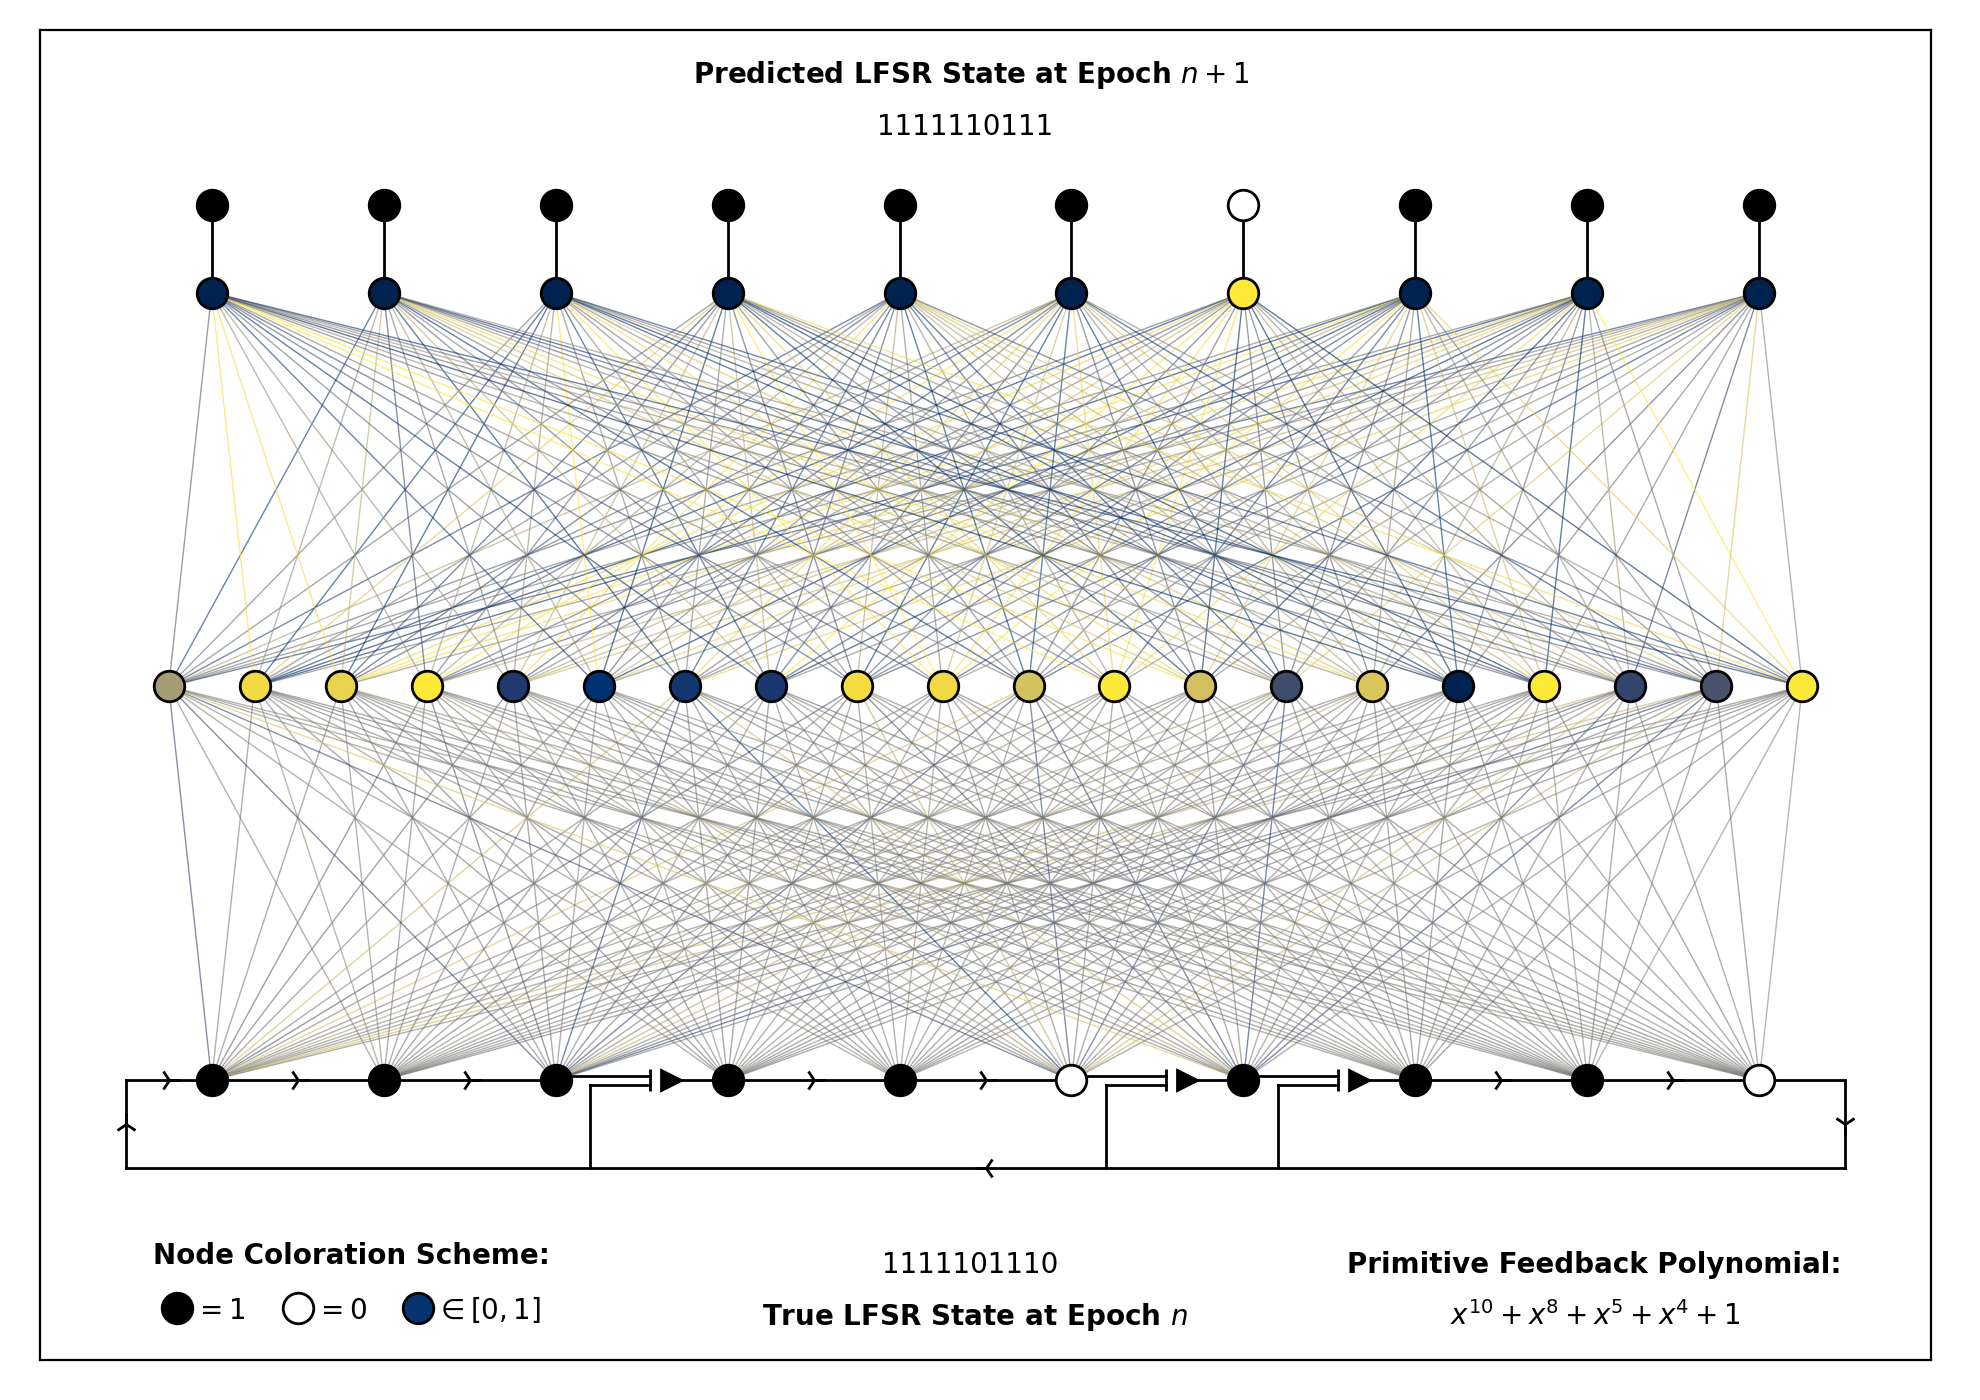

In [24]:
##############################
# Visualization config panel #
##############################

config = {
    'figsize': (9.9, 7),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'cividis',
    'y_input': 0,
    'y_hidden': 0.45,
    'y_output': 0.9,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'ylim': [-0.32, 1.2],
    'num_hidden': 2 * deg,
    'num_input': deg,
    'num_output': deg,
    'node_size': 10,
    'link_width': 1,
    'net_link_alpha': 0.6,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

lfsr_prediction_animation(
    lfsr=LFSRs[p], config=config, model=model,
    state_sequence=X, hidden_activations=hidden_activations,
    output_activations=output_activations,
    run_animation=True, interval=1000, blit=True, repeat=True)